In [1]:
#Alumnos:
#Bobadilla Catalan, German - 90123
#Briglia, Antonella - 90903
#Calvani, Sergio Alejandro - 98588
#Valdivia, Josue Giovanni - 93075

# Trabajo Práctico Nro 1 - Grupo 10

## 1) Importamos las librerías y cargamos los datos

In [143]:
#Importamos las librerias
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as datetime
import plotly as px
from langdetect import detect as lng
from shapely.geometry import Point
from matplotlib.colors import ListedColormap

%matplotlib inline
plt.style.use('default')
sns.set(style="whitegrid")

In [144]:
#Cargamos el csv
tweets=pd.read_csv('Data/CSV/train.csv')
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [145]:
#Veamos los tipos de datos de cada columna
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [146]:
#¿Hay valores nulos?
tweets.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [147]:
#Anteriormente vimos que hat nulos en keyword y location, veamos cuantos valores hay
tweets.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [148]:
#Cargamos el shp de los estados de usa
#Descargado del link: https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5
shp_usa_states="Data/Mapas/Estados_Usa/states.shp"
usa_estados=gpd.read_file(shp_usa_states)
usa_estados=usa_estados[(usa_estados['STATE_NAME']!='Alaska') & (usa_estados['STATE_NAME']!='Hawaii')]
usa_estados.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...
5,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...


In [149]:
#Cargamos el csv de ciudades para poder contar mejor la cantidad de tweets por pais
#Descargado del link: 
ciudades=pd.read_csv('Data/CSV/worldcities.csv')
ciudades=ciudades[['city','iso3']]
ciudades.head()

,city,iso3
0,Tokyo,JPN
1,New York,USA
2,Mexico City,MEX
3,Mumbai,IND
4,São Paulo,BRA


In [150]:
#Se crea el DataFrame con los idiomas y su abreviacion segun el codigo 'ISO 639-1'
idiomas_datos=[['ar','Árabe'],['af','Afrikáans'],['be','Bielorruso'],['et','Estonio' ],['tl','Tagalo'],['sw','Suajili' ],['fi','Finlandés'],['tr','turco'],['bs','Bosnio'],['ca','Catalán'],['cs','Checo'],['cy','Galés'],['da','Danés'],['de','Alemán'],['el','Griego'],['en','Inglés'],['eo','Esperanto'],['es','Español'],['fr','Francés'],['ga','Irlandés'],['gl','Gallego'],['gn','Guaraní'],['hr','Croata'],['ht','Haitiano'],['hu','Húngaro'],['hy','Armenio'],['hz','Herero'],['id','Indonesio'],['is','Islandés'],['it','Italiano'],['ja','Japonés'],['ko','Coreano'],['lt','Lituano'],['nl','Holandés'],['no','Noruego'],['pl','Polaco'],['pt','Portugués'],['ro','Rumano'],['ru','Ruso'],['sk','Eslovaco'],['sl','Esloveno'],['so','Somalí'],['sq','Albanés'],['sr','Serbio'],['ss','Suazi'],['st','Sesotho'],['su','Sundanés'],['sv','Sueco'],['to','Tongano'],['ty','Tahitiano'],['uk','Ucraniano'],['vi','Vietnamita'],['zh','Chino']]
idiomas=pd.DataFrame(idiomas_datos,columns=['ISO_639-1','nombre'])
idiomas.head()

,ISO_639-1,nombre
0,ar,Árabe
1,af,Afrikáans
2,be,Bielorruso
3,et,Estonio
4,tl,Tagalo


Poniendonos a analizar el caso de los valores nulos, se ve que las columnas 'keyword' y 'location' son las que tienen valores nulos, lo cual tiene sentido ya que no siempre se puede obtener la ubicacion del tweet, y en cuanto a 'keyword', si bien es más inusual que tenga valores nulos, tambien tiene sentido ya que no es un campo obligatorio

In [151]:
tweets['Tiene_arroba']=tweets['text'].str.contains('@')
tweets['Tiene_hashtag']=tweets['text'].str.contains('#')
tweets['Tiene_signo_pregunta']=tweets['text'].str.contains('\?|¿')
tweets['Tiene_signo_exclamacion']=tweets['text'].str.contains('!|¡')
tweets['Tiene_link']=tweets['text'].str.contains('https')

### 1.1) Funciones

In [152]:
#Para quedarme con el pais en relacion a dos valores
def MeQuedoConPais(primero,segundo):
    if((pd.isna(primero)) and (pd.notna(segundo))):
        return segundo
    if((pd.notna(primero)) and (pd.isna(segundo))):
        return primero
    else:
        return 'Vacio'

In [153]:
#Para quedarme con el pais en relacion a tres valores
def KeywordPaisFinal(primero,segundo,tercero):
    if((pd.notna(primero)) and (pd.isna(segundo)) and (pd.isna(tercero))):
        return primero
    if((pd.isna(primero)) and (pd.notna(segundo)) and (pd.isna(tercero))):
        return segundo
    if((pd.isna(primero)) and (pd.isna(segundo)) and (pd.notna(tercero))):
        return tercero
    if((pd.notna(primero)) and (pd.notna(segundo)) and (pd.notna(tercero))):
        return primero
    else:
        return 'Vacio'

In [154]:
#Función que establece si la locacion tiene USA
def TieneUsa(primero,segundo,tercero):
    if((primero=='USA') or (segundo=='USA') or (tercero=='USA')):
        return 1
    else:
        return 0

## 2) Análisis por Localización

In [155]:
#Cargamos el mapa del mundo que viene incluido en la libreria de geopandas
mundo=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mundo.replace({'United States of America':'United States'},inplace=True)
mundo.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [156]:
#Separo la locacion por comas para poder separar las ciudades de los paises
separacion_coma=pd.concat([tweets, tweets['location'].str.split(',', expand=True)], axis=1)
separacion_coma.dropna(subset=['location'],inplace=True)
separacion_coma.rename(columns={0:'Primero',1:'Segundo',2:'Tercero'},inplace=True)
separacion_coma.drop(columns={'location',3},inplace=True)
separacion_coma.head()

,id,keyword,text,target,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,Primero,Segundo,Tercero
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,True,False,False,False,False,Birmingham,None,None
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,False,True,False,False,False,Est. September 2012 - Bristol,None,None
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,False,True,False,False,False,AFRICA,None,None
34,52,ablaze,Crying out for more! Set me ablaze,0,False,False,False,True,False,Philadelphia,PA,None
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,False,False,False,False,False,London,UK,None


In [157]:
#Por si las dudas, borro el espacio que puede llegar a aparecer en el principio
separacion_coma['Primero']=separacion_coma['Primero'].str.lstrip(' ')
separacion_coma['Segundo']=separacion_coma['Segundo'].str.lstrip(' ')
separacion_coma['Tercero']=separacion_coma['Tercero'].str.lstrip(' ')

In [158]:
#Lo mismo que arriba pero al final
separacion_coma['Primero']=separacion_coma['Primero'].str.rstrip(' ')
separacion_coma['Segundo']=separacion_coma['Segundo'].str.rstrip(' ')
separacion_coma['Tercero']=separacion_coma['Tercero'].str.rstrip(' ')

In [159]:
#Me fijo si en alguna de esas tres columnas se encuentra el valor USA
separacion_coma['Es_USA']=separacion_coma.apply(lambda x: TieneUsa(x['Primero'],x['Segundo'],x['Tercero']),axis=1)

In [160]:
#Me quedo con los que su target es real y falso
separacion_coma_real=separacion_coma[(separacion_coma['target']==1)]
separacion_coma_falso=separacion_coma[(separacion_coma['target']==0)]

Hacemos un value counts por la separación

In [161]:
cantidad_primero=separacion_coma['Primero'].value_counts().reset_index()
cantidad_primero.rename(columns={'index':'name','Primero':'Cantidad_primero'},inplace=True)
cantidad_primero_real=separacion_coma_real['Primero'].value_counts().reset_index()
cantidad_primero_real.rename(columns={'index':'name','Primero':'Cantidad_primero_real'},inplace=True)
cantidad_primero_falso=separacion_coma_falso['Primero'].value_counts().reset_index()
cantidad_primero_falso.rename(columns={'index':'name','Primero':'Cantidad_primero_falso'},inplace=True)
cantidad_primero=pd.merge(cantidad_primero,cantidad_primero_real,on='name',how='left')
cantidad_primero=pd.merge(cantidad_primero,cantidad_primero_falso,on='name',how='left')
cantidad_primero.head()

,name,Cantidad_primero,Cantidad_primero_real,Cantidad_primero_falso
0,USA,110,70.0,40.0
1,New York,97,26.0,71.0
2,London,71,25.0,46.0
3,United States,50,27.0,23.0
4,Los Angeles,47,17.0,30.0


In [162]:
cantidad_segundo=separacion_coma['Segundo'].value_counts().reset_index()
cantidad_segundo.rename(columns={'index':'name','Segundo':'Cantidad_segundo'},inplace=True)
cantidad_segundo_real=separacion_coma_real['Segundo'].value_counts().reset_index()
cantidad_segundo_real.rename(columns={'index':'name','Segundo':'Cantidad_segundo_real'},inplace=True)
cantidad_segundo_falso=separacion_coma_falso['Segundo'].value_counts().reset_index()
cantidad_segundo_falso.rename(columns={'index':'name','Segundo':'Cantidad_segundo_falso'},inplace=True)
cantidad_segundo=pd.merge(cantidad_segundo,cantidad_segundo_real,on='name',how='left')
cantidad_segundo=pd.merge(cantidad_segundo,cantidad_segundo_falso,on='name',how='left')
cantidad_segundo.head()

,name,Cantidad_segundo,Cantidad_segundo_real,Cantidad_segundo_falso
0,CA,123,51.0,72.0
1,USA,104,34.0,70.0
2,NY,51,19.0,32.0
3,TX,50,20.0,30.0
4,England,48,12.0,36.0


In [163]:
cantidad_tercero=separacion_coma['Tercero'].value_counts().reset_index()
cantidad_tercero.rename(columns={'index':'name','Tercero':'Cantidad_tercero'},inplace=True)
cantidad_tercero_real=separacion_coma_real['Tercero'].value_counts().reset_index()
cantidad_tercero_real.rename(columns={'index':'name','Tercero':'Cantidad_tercero_real'},inplace=True)
cantidad_tercero_falso=separacion_coma_falso['Tercero'].value_counts().reset_index()
cantidad_tercero_falso.rename(columns={'index':'name','Tercero':'Cantidad_tercero_falso'},inplace=True)
cantidad_tercero=pd.merge(cantidad_tercero,cantidad_tercero_real,on='name',how='left')
cantidad_tercero=pd.merge(cantidad_tercero,cantidad_tercero_falso,on='name',how='left')
cantidad_tercero.head()

,name,Cantidad_tercero,Cantidad_tercero_real,Cantidad_tercero_falso
0,Canada,17,11.0,6.0
1,USA,14,11.0,3.0
2,UK,6,2.0,4.0
3,Australia,5,3.0,2.0
4,CA,3,2.0,1.0


Ahora bien, puede suceder que no haya ninguna coma y que en la locacion aparezca directamente el nombre o abreviación del Pais, o bien que se encuentre de la manera Estado,Pais, o tambien Ciudad,Estado,Pais, por lo que hay que contar por todas las separaciones. Luego veremos el caso específico de Estados Unidos, ya que, al ser uno de los principales paises del mundo en relación al foco de las noticias, vamos a analizar sus estados de manera independiente

### 2.2) Cantidad de Tweets por País

#### 2.2.1) Contar por País

In [164]:
cantidad_pais_primero=pd.merge(mundo,cantidad_primero,on='name',how='left')
cantidad_pais_primero.rename(columns={'name':'Pais','iso_a3':'name'},inplace=True)
cantidad_pais_primero=pd.merge(cantidad_pais_primero,cantidad_primero,on='name',how='left')
cantidad_pais_primero.fillna(value={'Cantidad_primero_x':0,'Cantidad_primero_real_x':0,'Cantidad_primero_falso_x':0,'Cantidad_primero_y':0,'Cantidad_primero_real_y':0,'Cantidad_primero_falso_y':0},inplace=True)
cantidad_pais_primero['Cantidad_primero']=cantidad_pais_primero['Cantidad_primero_x']+cantidad_pais_primero['Cantidad_primero_y']
cantidad_pais_primero['Cantidad_primero_real']=cantidad_pais_primero['Cantidad_primero_real_x']+cantidad_pais_primero['Cantidad_primero_real_y']
cantidad_pais_primero['Cantidad_primero_falso']=cantidad_pais_primero['Cantidad_primero_falso_x']+cantidad_pais_primero['Cantidad_primero_falso_y']
cantidad_pais_primero.drop(columns={'Cantidad_primero_x','Cantidad_primero_real_x','Cantidad_primero_falso_x','Cantidad_primero_y','Cantidad_primero_real_y','Cantidad_primero_falso_y'},inplace=True)
cantidad_pais_primero.head()

,pop_est,continent,Pais,name,gdp_md_est,geometry,Cantidad_primero,Cantidad_primero_real,Cantidad_primero_falso
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",0.0,0.0,0.0
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...,0.0,0.0,0.0
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...,0.0,0.0,0.0
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",30.0,13.0,17.0
4,326625791,North America,United States,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",160.0,97.0,63.0


In [165]:
cantidad_pais_segundo=pd.merge(mundo,cantidad_segundo,on='name',how='left')
cantidad_pais_segundo.rename(columns={'name':'Pais','iso_a3':'name'},inplace=True)
cantidad_pais_segundo=pd.merge(cantidad_pais_segundo,cantidad_segundo,on='name',how='left')
cantidad_pais_segundo.fillna(value={'Cantidad_segundo_x':0,'Cantidad_segundo_real_x':0,'Cantidad_segundo_falso_x':0,'Cantidad_segundo_y':0,'Cantidad_segundo_real_y':0,'Cantidad_segundo_falso_y':0},inplace=True)
cantidad_pais_segundo['Cantidad_segundo']=cantidad_pais_segundo['Cantidad_segundo_x']+cantidad_pais_segundo['Cantidad_segundo_y']
cantidad_pais_segundo['Cantidad_segundo_real']=cantidad_pais_segundo['Cantidad_segundo_real_x']+cantidad_pais_segundo['Cantidad_segundo_real_y']
cantidad_pais_segundo['Cantidad_segundo_falso']=cantidad_pais_segundo['Cantidad_segundo_falso_x']+cantidad_pais_segundo['Cantidad_segundo_falso_y']
cantidad_pais_segundo.drop(columns={'Cantidad_segundo_x','Cantidad_segundo_real_x','Cantidad_segundo_falso_x','Cantidad_segundo_y','Cantidad_segundo_real_y','Cantidad_segundo_falso_y'},inplace=True)
cantidad_pais_segundo=cantidad_pais_segundo[['Pais','Cantidad_segundo','Cantidad_segundo_real','Cantidad_segundo_falso']]
cantidad_pais_segundo.head()

,Pais,Cantidad_segundo,Cantidad_segundo_real,Cantidad_segundo_falso
0,Fiji,0.0,0.0,0.0
1,Tanzania,0.0,0.0,0.0
2,W. Sahara,0.0,0.0,0.0
3,Canada,18.0,7.0,11.0
4,United States,112.0,36.0,76.0


In [166]:
cantidad_pais_tercero=pd.merge(mundo,cantidad_tercero,on='name',how='left')
cantidad_pais_tercero.rename(columns={'name':'Pais','iso_a3':'name'},inplace=True)
cantidad_pais_tercero=pd.merge(cantidad_pais_tercero,cantidad_tercero,on='name',how='left')
cantidad_pais_tercero.fillna(value={'Cantidad_tercero_x':0,'Cantidad_tercero_real_x':0,'Cantidad_tercero_falso_x':0,'Cantidad_tercero_y':0,'Cantidad_tercero_real_y':0,'Cantidad_tercero_falso_y':0},inplace=True)
cantidad_pais_tercero['Cantidad_tercero']=cantidad_pais_tercero['Cantidad_tercero_x']+cantidad_pais_tercero['Cantidad_tercero_y']
cantidad_pais_tercero['Cantidad_tercero_real']=cantidad_pais_tercero['Cantidad_tercero_real_x']+cantidad_pais_tercero['Cantidad_tercero_real_y']
cantidad_pais_tercero['Cantidad_tercero_falso']=cantidad_pais_tercero['Cantidad_tercero_falso_x']+cantidad_pais_tercero['Cantidad_tercero_falso_y']
cantidad_pais_tercero.drop(columns={'Cantidad_tercero_x','Cantidad_tercero_real_x','Cantidad_tercero_falso_x','Cantidad_tercero_y','Cantidad_tercero_real_y','Cantidad_tercero_falso_y'},inplace=True)
cantidad_pais_tercero=cantidad_pais_tercero[['Pais','Cantidad_tercero','Cantidad_tercero_real','Cantidad_tercero_falso']]
cantidad_pais_tercero.head()

,Pais,Cantidad_tercero,Cantidad_tercero_real,Cantidad_tercero_falso
0,Fiji,0.0,0.0,0.0
1,Tanzania,0.0,0.0,0.0
2,W. Sahara,0.0,0.0,0.0
3,Canada,17.0,11.0,6.0
4,United States,15.0,11.0,4.0


In [167]:
cantidad_pais_total=pd.merge(cantidad_pais_primero,cantidad_pais_segundo,on='Pais',how='inner')
cantidad_pais_total=pd.merge(cantidad_pais_total,cantidad_pais_tercero,on='Pais',how='inner')
cantidad_pais_total['Cantidad_total']=cantidad_pais_total['Cantidad_primero']+cantidad_pais_total['Cantidad_segundo']+cantidad_pais_total['Cantidad_tercero']
cantidad_pais_total['Cantidad_real']=cantidad_pais_total['Cantidad_primero_real']+cantidad_pais_total['Cantidad_segundo_real']+cantidad_pais_total['Cantidad_tercero_real']
cantidad_pais_total['Cantidad_falso']=cantidad_pais_total['Cantidad_primero_falso']+cantidad_pais_total['Cantidad_segundo_falso']+cantidad_pais_total['Cantidad_tercero_falso']
cantidad_pais_total.drop(columns={'Cantidad_primero','Cantidad_segundo','Cantidad_tercero','Cantidad_primero_real','Cantidad_segundo_real','Cantidad_tercero_real','Cantidad_primero_falso','Cantidad_segundo_falso','Cantidad_tercero_falso'},inplace=True)
cantidad_pais_total.head()

,pop_est,continent,Pais,name,gdp_md_est,geometry,Cantidad_total,Cantidad_real,Cantidad_falso
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",0.0,0.0,0.0
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...,0.0,0.0,0.0
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...,0.0,0.0,0.0
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",65.0,31.0,34.0
4,326625791,North America,United States,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",287.0,144.0,143.0


A continuación contaremos la cantidad de veces que aparece una ciudad para tener con mayor exactitud la cantidad de tweets por país

#### 2.2.2) Contar por Ciudad

En esta caso, a Estados Unidos se lo excluye por el simple hecho de que vamos a hacer un análisis más exhaustivo más adelante

In [168]:
ciudades_sin_usa=ciudades[(ciudades['iso3']!='USA')]
ciudades_sin_usa.head()

,city,iso3
0,Tokyo,JPN
2,Mexico City,MEX
3,Mumbai,IND
4,São Paulo,BRA
5,Delhi,IND


In [169]:
ciudades_sin_usa_primero=ciudades[(ciudades['iso3']!='USA')].copy()
ciudades_sin_usa_primero.rename(columns={'city':'name'},inplace=True)
cantidad_ciudad_primero=pd.merge(ciudades_sin_usa_primero,cantidad_primero,on='name',how='left')
cantidad_ciudad_primero.fillna(value={'Cantidad_primero':0,'Cantidad_primero_real':0,'Cantidad_primero_falso':0},inplace=True)
cantidad_ciudad_primero.rename(columns={'name':'city','iso3':'name'},inplace=True)
cantidad_ciudad_primero.head()

,city,name,Cantidad_primero,Cantidad_primero_real,Cantidad_primero_falso
0,Tokyo,JPN,4.0,2.0,2.0
1,Mexico City,MEX,1.0,0.0,1.0
2,Mumbai,IND,29.0,24.0,5.0
3,São Paulo,BRA,0.0,0.0,0.0
4,Delhi,IND,2.0,0.0,2.0


In [170]:
ciudades_sin_usa_segundo=ciudades[(ciudades['iso3']!='USA')].copy()
ciudades_sin_usa_segundo.rename(columns={'city':'name'},inplace=True)
cantidad_ciudad_segundo=pd.merge(ciudades_sin_usa_segundo,cantidad_segundo,on='name',how='left')
cantidad_ciudad_segundo.fillna(value={'Cantidad_segundo':0,'Cantidad_segundo_real':0,'Cantidad_segundo_falso':0},inplace=True)
cantidad_ciudad_segundo.rename(columns={'name':'city','iso3':'name'},inplace=True)
cantidad_ciudad_segundo.head()

,city,name,Cantidad_segundo,Cantidad_segundo_real,Cantidad_segundo_falso
0,Tokyo,JPN,2.0,1.0,1.0
1,Mexico City,MEX,0.0,0.0,0.0
2,Mumbai,IND,0.0,0.0,0.0
3,São Paulo,BRA,0.0,0.0,0.0
4,Delhi,IND,2.0,1.0,1.0


In [171]:
ciudades_sin_usa_tercero=ciudades[(ciudades['iso3']!='USA')].copy()
ciudades_sin_usa_tercero.rename(columns={'city':'name'},inplace=True)
cantidad_ciudad_tercero=pd.merge(ciudades_sin_usa_tercero,cantidad_tercero,on='name',how='left')
cantidad_ciudad_tercero.fillna(value={'Cantidad_tercero':0,'Cantidad_tercero_real':0,'Cantidad_tercero_falso':0},inplace=True)
cantidad_ciudad_tercero.rename(columns={'name':'city','iso3':'name'},inplace=True)
cantidad_ciudad_tercero.head()

,city,name,Cantidad_tercero,Cantidad_tercero_real,Cantidad_tercero_falso
0,Tokyo,JPN,1.0,0.0,1.0
1,Mexico City,MEX,0.0,0.0,0.0
2,Mumbai,IND,0.0,0.0,0.0
3,São Paulo,BRA,0.0,0.0,0.0
4,Delhi,IND,0.0,0.0,0.0


In [172]:
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_primero,cantidad_ciudad_segundo,on='city',how='inner')
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_sin_usa,cantidad_ciudad_tercero,on='city',how='inner')
cantidad_ciudad_sin_usa['Cantidad_total']=cantidad_ciudad_sin_usa['Cantidad_primero']+cantidad_ciudad_sin_usa['Cantidad_segundo']+cantidad_ciudad_sin_usa['Cantidad_tercero']
cantidad_ciudad_sin_usa['Cantidad_real']=cantidad_ciudad_sin_usa['Cantidad_primero_real']+cantidad_ciudad_sin_usa['Cantidad_segundo_real']+cantidad_ciudad_sin_usa['Cantidad_tercero_real']
cantidad_ciudad_sin_usa['Cantidad_falso']=cantidad_ciudad_sin_usa['Cantidad_primero_falso']+cantidad_ciudad_sin_usa['Cantidad_segundo_falso']+cantidad_ciudad_sin_usa['Cantidad_tercero_falso']
cantidad_ciudad_sin_usa.drop(columns={'Cantidad_primero','Cantidad_segundo','Cantidad_tercero','Cantidad_primero_real','Cantidad_segundo_real','Cantidad_tercero_real','Cantidad_primero_falso','Cantidad_segundo_falso','Cantidad_tercero_falso','name_x','name_y'},inplace=True)
cantidad_ciudad_sin_usa.head()

,city,name,Cantidad_total,Cantidad_real,Cantidad_falso
0,Tokyo,JPN,7.0,3.0,4.0
1,Mexico City,MEX,1.0,0.0,1.0
2,Mumbai,IND,29.0,24.0,5.0
3,São Paulo,BRA,0.0,0.0,0.0
4,Delhi,IND,4.0,1.0,3.0


In [173]:
cantidad_ciudad_sin_usa_total=cantidad_ciudad_sin_usa.groupby(['city']).agg({'Cantidad_total':'mean'})
cantidad_ciudad_sin_usa_real=cantidad_ciudad_sin_usa.groupby(['city']).agg({'Cantidad_real':'mean'})
cantidad_ciudad_sin_usa_falso=cantidad_ciudad_sin_usa.groupby(['city']).agg({'Cantidad_falso':'mean'})
cantidad_ciudad_sin_usa_total=cantidad_ciudad_sin_usa_total.reset_index()
cantidad_ciudad_sin_usa_real=cantidad_ciudad_sin_usa_real.reset_index()
cantidad_ciudad_sin_usa_falso=cantidad_ciudad_sin_usa_falso.reset_index()
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_sin_usa_total,cantidad_ciudad_sin_usa_real,on='city',how='inner')
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_sin_usa,cantidad_ciudad_sin_usa_falso,on='city',how='inner')
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_sin_usa,ciudades_sin_usa,on='city',how='inner')
cantidad_ciudad_sin_usa.rename(columns={'iso3':'name'},inplace=True)
cantidad_ciudad_sin_usa.head()

,city,Cantidad_total,Cantidad_real,Cantidad_falso,name
0,A Coruña,0.0,0.0,0.0,ESP
1,Aalborg,0.0,0.0,0.0,DNK
2,Aarau,0.0,0.0,0.0,CHE
3,Aarau,0.0,0.0,0.0,CHE
4,Aarhus,1.0,0.0,1.0,DNK


In [174]:
cantidad_ciudad_pais_total=cantidad_ciudad_sin_usa.groupby(['name']).agg({'Cantidad_total':'sum'})
cantidad_ciudad_pais_real=cantidad_ciudad_sin_usa.groupby(['name']).agg({'Cantidad_real':'sum'})
cantidad_ciudad_pais_falso=cantidad_ciudad_sin_usa.groupby(['name']).agg({'Cantidad_falso':'sum'})
cantidad_ciudad_pais_total=cantidad_ciudad_pais_total.reset_index()
cantidad_ciudad_pais_real=cantidad_ciudad_pais_real.reset_index()
cantidad_ciudad_pais_falso=cantidad_ciudad_pais_falso.reset_index()
cantidad_ciudad_pais=pd.merge(cantidad_ciudad_pais_total,cantidad_ciudad_pais_real,on='name',how='left')
cantidad_ciudad_pais=pd.merge(cantidad_ciudad_pais,cantidad_ciudad_pais_falso,on='name',how='left')
cantidad_ciudad_pais.head()

,name,Cantidad_total,Cantidad_real,Cantidad_falso
0,ABW,0.0,0.0,0.0
1,AFG,1.0,0.0,1.0
2,AGO,0.0,0.0,0.0
3,ALB,0.0,0.0,0.0
4,AND,0.0,0.0,0.0


In [175]:
cantidad_pais_total=pd.merge(cantidad_pais_total,cantidad_ciudad_pais,on='name',how='left')
cantidad_pais_total.fillna(value={'Cantidad_total_y':0,'Cantidad_real_y':0,'Cantidad_falso_y':0},inplace=True)
cantidad_pais_total['Cantidad_total']=cantidad_pais_total['Cantidad_total_x']+cantidad_pais_total['Cantidad_total_y']
cantidad_pais_total['Cantidad_real']=cantidad_pais_total['Cantidad_real_x']+cantidad_pais_total['Cantidad_real_y']
cantidad_pais_total['Cantidad_falso']=cantidad_pais_total['Cantidad_falso_x']+cantidad_pais_total['Cantidad_falso_y']
cantidad_pais_total.drop(columns={'Cantidad_total_x','Cantidad_total_y','Cantidad_real_x','Cantidad_real_y','Cantidad_falso_x','Cantidad_falso_y'},inplace=True)
cantidad_pais_total.head()

,pop_est,continent,Pais,name,gdp_md_est,geometry,Cantidad_total,Cantidad_real,Cantidad_falso
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",1.0,0.0,1.0
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...,0.0,0.0,0.0
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...,0.0,0.0,0.0
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",284.0,139.0,145.0
4,326625791,North America,United States,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",287.0,144.0,143.0


#### 2.2.3) Estados Sin USA

In [176]:
estados_sin_usa_total=separacion_coma[(separacion_coma['Es_USA']==0)]
estados_sin_usa_real=separacion_coma_real[(separacion_coma_real['Es_USA']==0)]
estados_sin_usa_falso=separacion_coma_falso[(separacion_coma_falso['Es_USA']==0)]
cantidad_primero_sin_usa_total=estados_sin_usa_total['Primero'].value_counts().reset_index()
cantidad_primero_sin_usa_total.rename(columns={'index':'name','Primero':'Cantidad_primero_total'},inplace=True)
cantidad_primero_sin_usa_real=estados_sin_usa_real['Primero'].value_counts().reset_index()
cantidad_primero_sin_usa_real.rename(columns={'index':'name','Primero':'Cantidad_primero_real'},inplace=True)
cantidad_primero_sin_usa_falso=estados_sin_usa_falso['Primero'].value_counts().reset_index()
cantidad_primero_sin_usa_falso.rename(columns={'index':'name','Primero':'Cantidad_primero_falso'},inplace=True)
cantidad_primero_sin_usa=pd.merge(cantidad_primero_sin_usa_total,cantidad_primero_sin_usa_real,on='name',how='left')
cantidad_primero_sin_usa=pd.merge(cantidad_primero_sin_usa,cantidad_primero_sin_usa_falso,on='name',how='left')
cantidad_primero_sin_usa.head()

,name,Cantidad_primero_total,Cantidad_primero_real,Cantidad_primero_falso
0,New York,92,25.0,67.0
1,London,71,25.0,46.0
2,United States,50,27.0,23.0
3,Los Angeles,46,17.0,29.0
4,Washington,43,30.0,13.0


In [177]:
cantidad_segundo_sin_usa_total=estados_sin_usa_total['Segundo'].value_counts().reset_index()
cantidad_segundo_sin_usa_total.rename(columns={'index':'name','Segundo':'Cantidad_segundo_total'},inplace=True)
cantidad_segundo_sin_usa_real=estados_sin_usa_real['Segundo'].value_counts().reset_index()
cantidad_segundo_sin_usa_real.rename(columns={'index':'name','Segundo':'Cantidad_segundo_real'},inplace=True)
cantidad_segundo_sin_usa_falso=estados_sin_usa_falso['Segundo'].value_counts().reset_index()
cantidad_segundo_sin_usa_falso.rename(columns={'index':'name','Segundo':'Cantidad_segundo_falso'},inplace=True)
cantidad_segundo_sin_usa=pd.merge(cantidad_segundo_sin_usa_total,cantidad_segundo_sin_usa_real,on='name',how='left')
cantidad_segundo_sin_usa=pd.merge(cantidad_segundo_sin_usa,cantidad_segundo_sin_usa_falso,on='name',how='left')
cantidad_segundo_sin_usa.head()

,name,Cantidad_segundo_total,Cantidad_segundo_real,Cantidad_segundo_falso
0,CA,120,49.0,71.0
1,NY,51,19.0,32.0
2,TX,50,20.0,30.0
3,England,48,12.0,36.0
4,FL,43,17.0,26.0


In [178]:
cantidad_tercero_sin_usa_total=estados_sin_usa_total['Tercero'].value_counts().reset_index()
cantidad_tercero_sin_usa_total.rename(columns={'index':'name','Tercero':'Cantidad_tercero_total'},inplace=True)
cantidad_tercero_sin_usa_real=estados_sin_usa_real['Tercero'].value_counts().reset_index()
cantidad_tercero_sin_usa_real.rename(columns={'index':'name','Tercero':'Cantidad_tercero_real'},inplace=True)
cantidad_tercero_sin_usa_falso=estados_sin_usa_falso['Tercero'].value_counts().reset_index()
cantidad_tercero_sin_usa_falso.rename(columns={'index':'name','Tercero':'Cantidad_tercero_falso'},inplace=True)
cantidad_tercero_sin_usa=pd.merge(cantidad_tercero_sin_usa_total,cantidad_tercero_sin_usa_real,on='name',how='left')
cantidad_tercero_sin_usa=pd.merge(cantidad_tercero_sin_usa,cantidad_tercero_sin_usa_falso,on='name',how='left')
cantidad_tercero_sin_usa.head()

,name,Cantidad_tercero_total,Cantidad_tercero_real,Cantidad_tercero_falso
0,Canada,17,11.0,6.0
1,UK,6,2.0,4.0
2,Australia,5,3.0,2.0
3,CA,3,2.0,1.0
4,Nigeria,3,2.0,1.0


In [179]:
usa_estados.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...
5,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...


In [180]:
estados_primero_sin_usa=usa_estados.copy()
estados_primero_sin_usa.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_primero_sin_usa=pd.merge(estados_primero_sin_usa,cantidad_primero_sin_usa,on='name',how='left')
cantidad_estados_primero_sin_usa.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_primero_sin_usa=pd.merge(cantidad_estados_primero_sin_usa,cantidad_primero_sin_usa,on='name',how='left')
cantidad_estados_primero_sin_usa.fillna(value={'Cantidad_primero_total_x':0,'Cantidad_primero_real_x':0,'Cantidad_primero_falso_x':0,'Cantidad_primero_total_y':0,'Cantidad_primero_real_y':0,'Cantidad_primero_falso_y':0},inplace=True)
cantidad_estados_primero_sin_usa['Cantidad_primero_total']=cantidad_estados_primero_sin_usa['Cantidad_primero_total_x']+cantidad_estados_primero_sin_usa['Cantidad_primero_total_y']
cantidad_estados_primero_sin_usa['Cantidad_primero_real']=cantidad_estados_primero_sin_usa['Cantidad_primero_real_x']+cantidad_estados_primero_sin_usa['Cantidad_primero_real_y']
cantidad_estados_primero_sin_usa['Cantidad_primero_falso']=cantidad_estados_primero_sin_usa['Cantidad_primero_falso_x']+cantidad_estados_primero_sin_usa['Cantidad_primero_falso_y']
cantidad_estados_primero_sin_usa.drop(columns={'Cantidad_primero_total_x','Cantidad_primero_real_x','Cantidad_primero_falso_x','Cantidad_primero_total_y','Cantidad_primero_real_y','Cantidad_primero_falso_y'},inplace=True)
cantidad_estados_primero_sin_usa.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_primero_total,Cantidad_primero_real,Cantidad_primero_falso
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,43.0,30.0,13.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,1.0,1.0,0.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,0.0,0.0,0.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,0.0,0.0,0.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,0.0,0.0,0.0


In [181]:
cantidad_estados_primero_sin_usa_total=cantidad_estados_primero_sin_usa['Cantidad_primero_total'].sum()
cantidad_estados_primero_sin_usa_real=cantidad_estados_primero_sin_usa['Cantidad_primero_real'].sum()
cantidad_estados_primero_sin_usa_falso=cantidad_estados_primero_sin_usa['Cantidad_primero_falso'].sum()

In [182]:
estados_segundo_sin_usa=usa_estados.copy()
estados_segundo_sin_usa.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_segundo_sin_usa=pd.merge(estados_segundo_sin_usa,cantidad_segundo_sin_usa,on='name',how='left')
cantidad_estados_segundo_sin_usa.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_segundo_sin_usa=pd.merge(cantidad_estados_segundo_sin_usa,cantidad_segundo_sin_usa,on='name',how='left')
cantidad_estados_segundo_sin_usa.fillna(value={'Cantidad_segundo_total_x':0,'Cantidad_segundo_real_x':0,'Cantidad_segundo_falso_x':0,'Cantidad_segundo_total_y':0,'Cantidad_segundo_real_y':0,'Cantidad_segundo_falso_y':0},inplace=True)
cantidad_estados_segundo_sin_usa['Cantidad_segundo_total']=cantidad_estados_segundo_sin_usa['Cantidad_segundo_total_x']+cantidad_estados_segundo_sin_usa['Cantidad_segundo_total_y']
cantidad_estados_segundo_sin_usa['Cantidad_segundo_real']=cantidad_estados_segundo_sin_usa['Cantidad_segundo_real_x']+cantidad_estados_segundo_sin_usa['Cantidad_segundo_real_y']
cantidad_estados_segundo_sin_usa['Cantidad_segundo_falso']=cantidad_estados_segundo_sin_usa['Cantidad_segundo_falso_x']+cantidad_estados_segundo_sin_usa['Cantidad_segundo_falso_y']
cantidad_estados_segundo_sin_usa.drop(columns={'Cantidad_segundo_total_x','Cantidad_segundo_real_x','Cantidad_segundo_falso_x','Cantidad_segundo_total_y','Cantidad_segundo_real_y','Cantidad_segundo_falso_y'},inplace=True)
cantidad_estados_segundo_sin_usa.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_segundo_total,Cantidad_segundo_real,Cantidad_segundo_falso
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,25.0,9.0,16.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,2.0,0.0,2.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,3.0,2.0,1.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,1.0,0.0,1.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,2.0,1.0,1.0


In [183]:
cantidad_estados_segundo_sin_usa_total=cantidad_estados_segundo_sin_usa['Cantidad_segundo_total'].sum()
cantidad_estados_segundo_sin_usa_real=cantidad_estados_segundo_sin_usa['Cantidad_segundo_real'].sum()
cantidad_estados_segundo_sin_usa_falso=cantidad_estados_segundo_sin_usa['Cantidad_segundo_falso'].sum()

In [184]:
estados_tercero_sin_usa=usa_estados.copy()
estados_tercero_sin_usa.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_tercero_sin_usa=pd.merge(estados_tercero_sin_usa,cantidad_tercero_sin_usa,on='name',how='left')
cantidad_estados_tercero_sin_usa.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_tercero_sin_usa=pd.merge(cantidad_estados_tercero_sin_usa,cantidad_tercero_sin_usa,on='name',how='left')
cantidad_estados_tercero_sin_usa.fillna(value={'Cantidad_tercero_total_x':0,'Cantidad_tercero_real_x':0,'Cantidad_tercero_falso_x':0,'Cantidad_tercero_total_y':0,'Cantidad_tercero_real_y':0,'Cantidad_tercero_falso_y':0},inplace=True)
cantidad_estados_tercero_sin_usa['Cantidad_tercero_total']=cantidad_estados_tercero_sin_usa['Cantidad_tercero_total_x']+cantidad_estados_tercero_sin_usa['Cantidad_tercero_total_y']
cantidad_estados_tercero_sin_usa['Cantidad_tercero_real']=cantidad_estados_tercero_sin_usa['Cantidad_tercero_real_x']+cantidad_estados_tercero_sin_usa['Cantidad_tercero_real_y']
cantidad_estados_tercero_sin_usa['Cantidad_tercero_falso']=cantidad_estados_tercero_sin_usa['Cantidad_tercero_falso_x']+cantidad_estados_tercero_sin_usa['Cantidad_tercero_falso_y']
cantidad_estados_tercero_sin_usa.drop(columns={'Cantidad_tercero_total_x','Cantidad_tercero_real_x','Cantidad_tercero_falso_x','Cantidad_tercero_total_y','Cantidad_tercero_real_y','Cantidad_tercero_falso_y'},inplace=True)
cantidad_estados_tercero_sin_usa.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_tercero_total,Cantidad_tercero_real,Cantidad_tercero_falso
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,0.0,0.0,0.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,0.0,0.0,0.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,0.0,0.0,0.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,0.0,0.0,0.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,1.0,1.0,0.0


In [185]:
cantidad_estados_tercero_sin_usa_total=cantidad_estados_tercero_sin_usa['Cantidad_tercero_total'].sum()
cantidad_estados_tercero_sin_usa_real=cantidad_estados_tercero_sin_usa['Cantidad_tercero_real'].sum()
cantidad_estados_tercero_sin_usa_falso=cantidad_estados_tercero_sin_usa['Cantidad_tercero_falso'].sum()

In [186]:
cantidad_estados_sin_usa_total=cantidad_estados_primero_sin_usa_total+cantidad_estados_segundo_sin_usa_total+cantidad_estados_tercero_sin_usa_total
cantidad_estados_sin_usa_real=cantidad_estados_primero_sin_usa_real+cantidad_estados_segundo_sin_usa_real+cantidad_estados_tercero_sin_usa_real
cantidad_estados_sin_usa_falso=cantidad_estados_primero_sin_usa_falso+cantidad_estados_segundo_sin_usa_falso+cantidad_estados_tercero_sin_usa_falso

In [187]:
cantidad_sin_usa=[['USA',cantidad_estados_sin_usa_total,cantidad_estados_sin_usa_real,cantidad_estados_sin_usa_falso]]
cantidad_estados_sin_usa=pd.DataFrame(cantidad_sin_usa,columns=['name','Cantidad_total_sin_usa','Cantidad_real_sin_usa','Cantidad_falso_sin_usa'])
cantidad_pais_total=pd.merge(cantidad_pais_total,cantidad_estados_sin_usa,on='name',how='left')
cantidad_pais_total.fillna(value={'Cantidad_total_sin_usa':0,'Cantidad_real_sin_usa':0,'Cantidad_falso_sin_usa':0},inplace=True)
cantidad_pais_total['Cantidad_total']=cantidad_pais_total['Cantidad_total']+cantidad_pais_total['Cantidad_total_sin_usa']
cantidad_pais_total['Cantidad_real']=cantidad_pais_total['Cantidad_real']+cantidad_pais_total['Cantidad_real_sin_usa']
cantidad_pais_total['Cantidad_falso']=cantidad_pais_total['Cantidad_falso']+cantidad_pais_total['Cantidad_falso_sin_usa']
cantidad_pais_total['Promedio_real']=(cantidad_pais_total['Cantidad_real']/cantidad_pais_total['Cantidad_total'])*100
cantidad_pais_total['Promedio_falso']=(cantidad_pais_total['Cantidad_falso']/cantidad_pais_total['Cantidad_total'])*100
cantidad_pais_total.drop(columns={'Cantidad_total_sin_usa','Cantidad_real_sin_usa','Cantidad_falso_sin_usa','Cantidad_real','Cantidad_falso'},inplace=True)
cantidad_pais_total.head()

,pop_est,continent,Pais,name,gdp_md_est,geometry,Cantidad_total,Promedio_real,Promedio_falso
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",1.0,0.000000,100.000000
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...,0.0,NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...,0.0,NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",284.0,48.943662,51.056338
4,326625791,North America,United States,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",1534.0,44.002608,55.997392


Text(0.5,1,'Cantidad de Tweets por País')

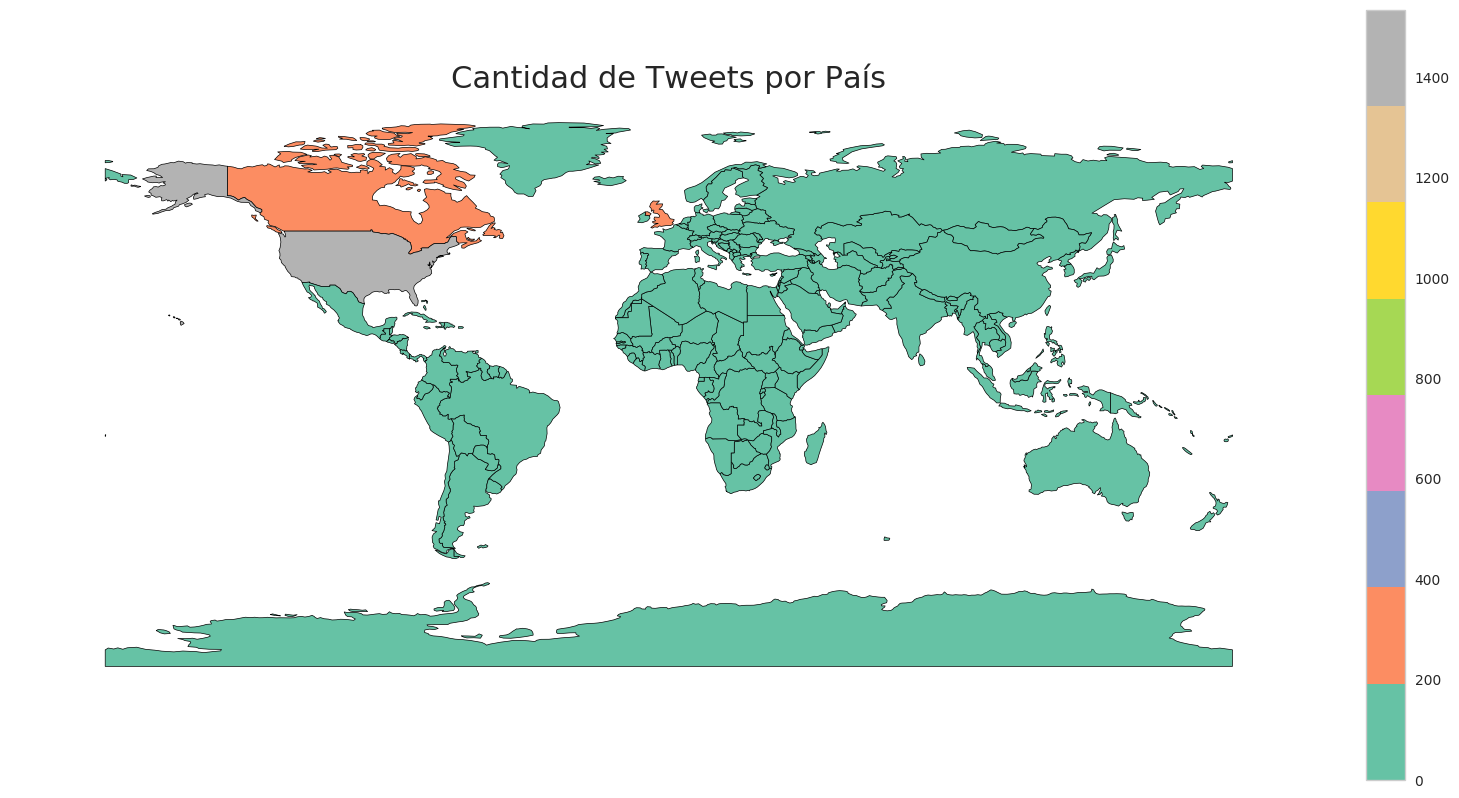

In [254]:
fig, grafico_cantidad_pais = plt.subplots(1, figsize=(20, 10))
cantidad_pais_total.plot(column='Cantidad_total',cmap='Set2', edgecolor='black',ax=grafico_cantidad_pais,legend=True,figsize=(30,30),linewidth=0.5)
grafico_cantidad_pais.axis('off')
grafico_cantidad_pais.set_title("Cantidad de Tweets por País",fontsize=22)

/home/sergio/.local/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning:

invalid value encountered in less



Text(0.5,1,'Promedio de Tweets Reales por País')

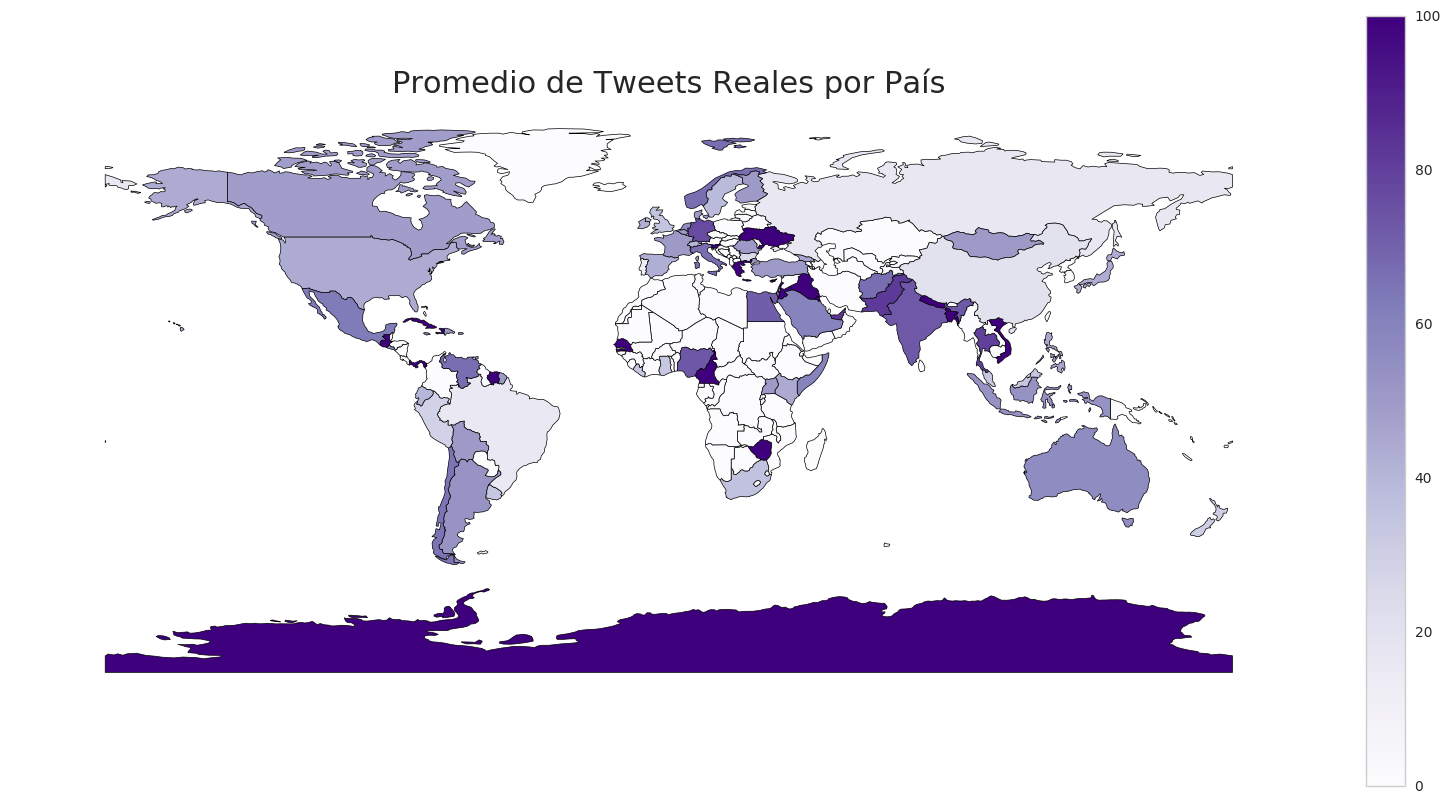

In [255]:
fig, grafico_promedio_real_pais = plt.subplots(1, figsize=(20, 10))
cantidad_pais_total.plot(column='Promedio_real',cmap='Purples', edgecolor='black',ax=grafico_promedio_real_pais,legend=True,figsize=(30,30),linewidth=0.5)
grafico_promedio_real_pais.axis('off')
grafico_promedio_real_pais.set_title("Promedio de Tweets Reales por País",fontsize=22)

/home/sergio/.local/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning:

invalid value encountered in less



Text(0.5,1,'Promedio de Tweets Falsos por País')

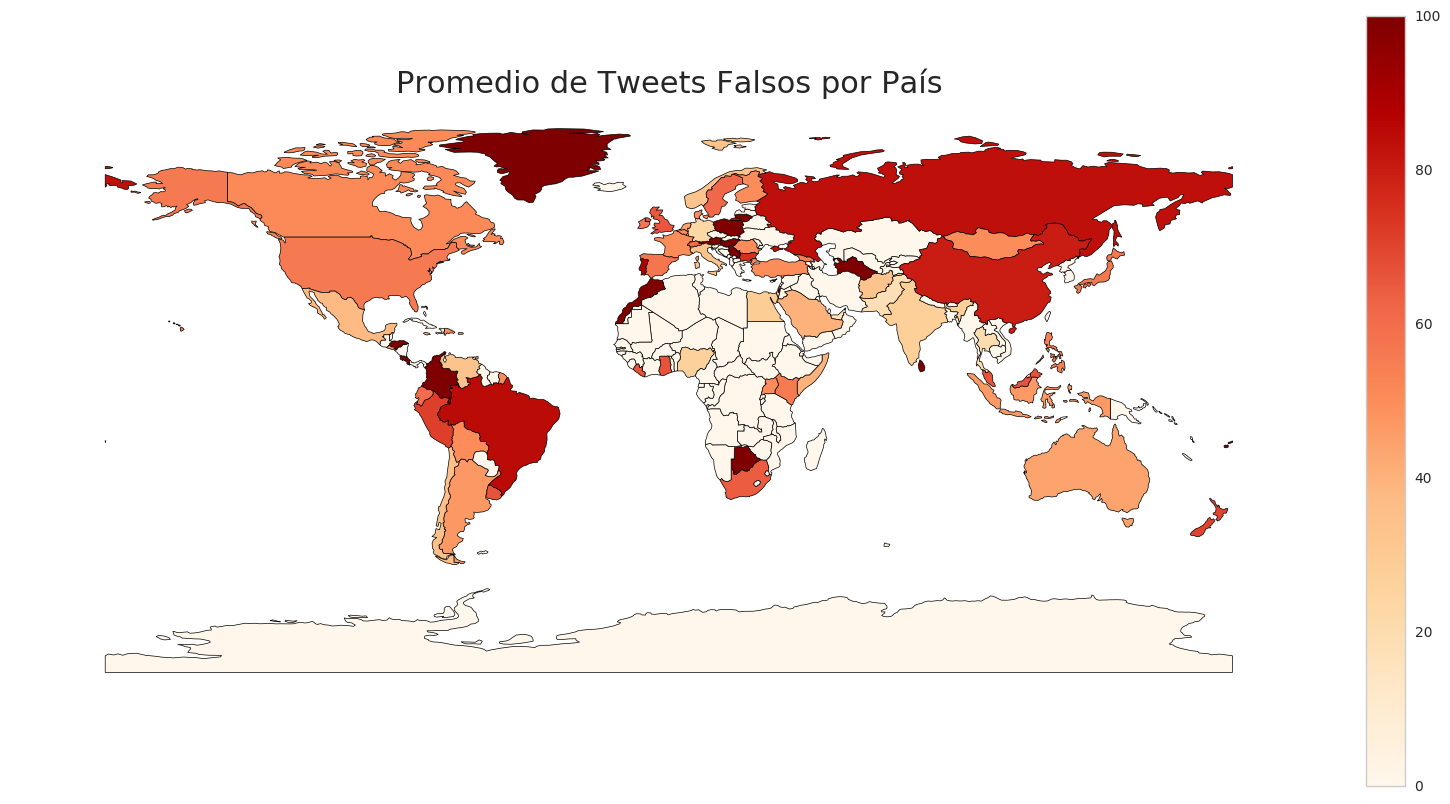

In [256]:
fig, grafico_promedio_falso_pais = plt.subplots(1, figsize=(20, 10))
cantidad_pais_total.plot(column='Promedio_falso',cmap='OrRd', edgecolor='black',ax=grafico_promedio_falso_pais,legend=True,figsize=(30,30),linewidth=0.5)
grafico_promedio_falso_pais.axis('off')
grafico_promedio_falso_pais.set_title("Promedio de Tweets Falsos por País",fontsize=22)

### 2.3 Estados de USA

In [191]:
estados_primero=usa_estados.copy()
estados_primero.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_primero=pd.merge(estados_primero,cantidad_primero,on='name',how='left')
cantidad_estados_primero.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_primero=pd.merge(cantidad_estados_primero,cantidad_primero,on='name',how='left')
cantidad_estados_primero.fillna(value={'Cantidad_primero_x':0,'Cantidad_primero_y':0,'Cantidad_primero_real_x':0,'Cantidad_primero_real_y':0,'Cantidad_primero_falso_x':0,'Cantidad_primero_falso_y':0},inplace=True)
cantidad_estados_primero['Cantidad_primero']=cantidad_estados_primero['Cantidad_primero_x']+cantidad_estados_primero['Cantidad_primero_y']
cantidad_estados_primero['Cantidad_primero_real']=cantidad_estados_primero['Cantidad_primero_real_x']+cantidad_estados_primero['Cantidad_primero_real_y']
cantidad_estados_primero['Cantidad_primero_falso']=cantidad_estados_primero['Cantidad_primero_falso_x']+cantidad_estados_primero['Cantidad_primero_falso_y']
cantidad_estados_primero.drop(columns={'Cantidad_primero_x','Cantidad_primero_y','Cantidad_primero_real_x','Cantidad_primero_real_y','Cantidad_primero_falso_x','Cantidad_primero_falso_y'},inplace=True)
cantidad_estados_primero.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_primero,Cantidad_primero_real,Cantidad_primero_falso
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,45.0,31.0,14.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,2.0,1.0,1.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,0.0,0.0,0.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,0.0,0.0,0.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,0.0,0.0,0.0


In [192]:
estados_segundo=usa_estados.copy()
estados_segundo.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_segundo=pd.merge(estados_segundo,cantidad_segundo,on='name',how='left')
cantidad_estados_segundo.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_segundo=pd.merge(cantidad_estados_segundo,cantidad_segundo,on='name',how='left')
cantidad_estados_segundo.fillna(value={'Cantidad_segundo_x':0,'Cantidad_segundo_y':0,'Cantidad_segundo_real_x':0,'Cantidad_segundo_real_y':0,'Cantidad_segundo_falso_x':0,'Cantidad_segundo_falso_y':0},inplace=True)
cantidad_estados_segundo['Cantidad_segundo']=cantidad_estados_segundo['Cantidad_segundo_x']+cantidad_estados_segundo['Cantidad_segundo_y']
cantidad_estados_segundo['Cantidad_segundo_real']=cantidad_estados_segundo['Cantidad_segundo_real_x']+cantidad_estados_segundo['Cantidad_segundo_real_y']
cantidad_estados_segundo['Cantidad_segundo_falso']=cantidad_estados_segundo['Cantidad_segundo_falso_x']+cantidad_estados_segundo['Cantidad_segundo_falso_y']
cantidad_estados_segundo.drop(columns={'Cantidad_segundo_x','Cantidad_segundo_y','Cantidad_segundo_real_x','Cantidad_segundo_real_y','Cantidad_segundo_falso_x','Cantidad_segundo_falso_y'},inplace=True)
cantidad_estados_segundo=cantidad_estados_segundo[['Estado','Cantidad_segundo','Cantidad_segundo_real','Cantidad_segundo_falso']]
cantidad_estados_segundo.head()

,Estado,Cantidad_segundo,Cantidad_segundo_real,Cantidad_segundo_falso
0,Washington,26.0,9.0,17.0
1,Montana,2.0,0.0,2.0
2,Maine,3.0,2.0,1.0
3,North Dakota,2.0,1.0,1.0
4,South Dakota,2.0,1.0,1.0


In [193]:
estados_tercero=usa_estados.copy()
estados_tercero.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_tercero=pd.merge(estados_tercero,cantidad_tercero,on='name',how='left')
cantidad_estados_tercero.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_tercero=pd.merge(cantidad_estados_tercero,cantidad_tercero,on='name',how='left')
cantidad_estados_tercero.fillna(value={'Cantidad_tercero_x':0,'Cantidad_tercero_y':0,'Cantidad_tercero_real_x':0,'Cantidad_tercero_real_y':0,'Cantidad_tercero_falso_x':0,'Cantidad_tercero_falso_y':0},inplace=True)
cantidad_estados_tercero['Cantidad_tercero']=cantidad_estados_tercero['Cantidad_tercero_x']+cantidad_estados_tercero['Cantidad_tercero_y']
cantidad_estados_tercero['Cantidad_tercero_real']=cantidad_estados_tercero['Cantidad_tercero_real_x']+cantidad_estados_tercero['Cantidad_tercero_real_y']
cantidad_estados_tercero['Cantidad_tercero_falso']=cantidad_estados_tercero['Cantidad_tercero_falso_x']+cantidad_estados_tercero['Cantidad_tercero_falso_y']
cantidad_estados_tercero.drop(columns={'Cantidad_tercero_x','Cantidad_tercero_y','Cantidad_tercero_real_x','Cantidad_tercero_real_y','Cantidad_tercero_falso_x','Cantidad_tercero_falso_y'},inplace=True)
cantidad_estados_tercero=cantidad_estados_tercero[['Estado','Cantidad_tercero','Cantidad_tercero_real','Cantidad_tercero_falso']]
cantidad_estados_tercero.head()

,Estado,Cantidad_tercero,Cantidad_tercero_real,Cantidad_tercero_falso
0,Washington,0.0,0.0,0.0
1,Montana,0.0,0.0,0.0
2,Maine,0.0,0.0,0.0
3,North Dakota,0.0,0.0,0.0
4,South Dakota,1.0,1.0,0.0


In [194]:
cantidad_estados_total=pd.merge(cantidad_estados_primero,cantidad_estados_segundo,on='Estado',how='inner')
cantidad_estados_total=pd.merge(cantidad_estados_total,cantidad_estados_tercero,on='Estado',how='inner')
cantidad_estados_total['Cantidad_total']=cantidad_estados_total['Cantidad_primero']+cantidad_estados_total['Cantidad_segundo']+cantidad_estados_total['Cantidad_tercero']
cantidad_estados_total['Cantidad_real']=cantidad_estados_total['Cantidad_primero_real']+cantidad_estados_total['Cantidad_segundo_real']+cantidad_estados_total['Cantidad_tercero_real']
cantidad_estados_total['Cantidad_falso']=cantidad_estados_total['Cantidad_primero_falso']+cantidad_estados_total['Cantidad_segundo_falso']+cantidad_estados_total['Cantidad_tercero_falso']
cantidad_estados_total['Promedio_real']=(cantidad_estados_total['Cantidad_real']/cantidad_estados_total['Cantidad_total'])*100
cantidad_estados_total['Promedio_falso']=(cantidad_estados_total['Cantidad_falso']/cantidad_estados_total['Cantidad_total'])*100
cantidad_estados_total.drop(columns={'Cantidad_primero','Cantidad_segundo','Cantidad_tercero','Cantidad_primero_real','Cantidad_segundo_real','Cantidad_tercero_real','Cantidad_primero_falso','Cantidad_segundo_falso','Cantidad_tercero_falso','Cantidad_real','Cantidad_falso'},inplace=True)
cantidad_estados_total.sort_values(by=['name'],inplace=True)
cantidad_estados_total.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_total,Promedio_real,Promedio_falso
41,Alabama,43,01,East South Central,AL,POLYGON ((-85.07006727561546 31.98070335724909...,14.0,57.142857,42.857143
45,Arkansas,47,05,West South Central,AR,POLYGON ((-94.46169128436209 34.19676535931296...,10.0,60.000000,40.000000
35,Arizona,37,04,Mountain,AZ,POLYGON ((-114.5206273030434 33.02770735822419...,23.0,47.826087,52.173913
23,California,25,06,Pacific,CA,(POLYGON ((-121.6652203096974 38.1692853630126...,191.0,44.502618,55.497382
30,Colorado,32,08,Mountain,CO,POLYGON ((-102.0444562914241 37.64147436252109...,37.0,56.756757,43.243243


Text(0.5,1,'Cantidad de Tweets por Estado en Estados Unidos')

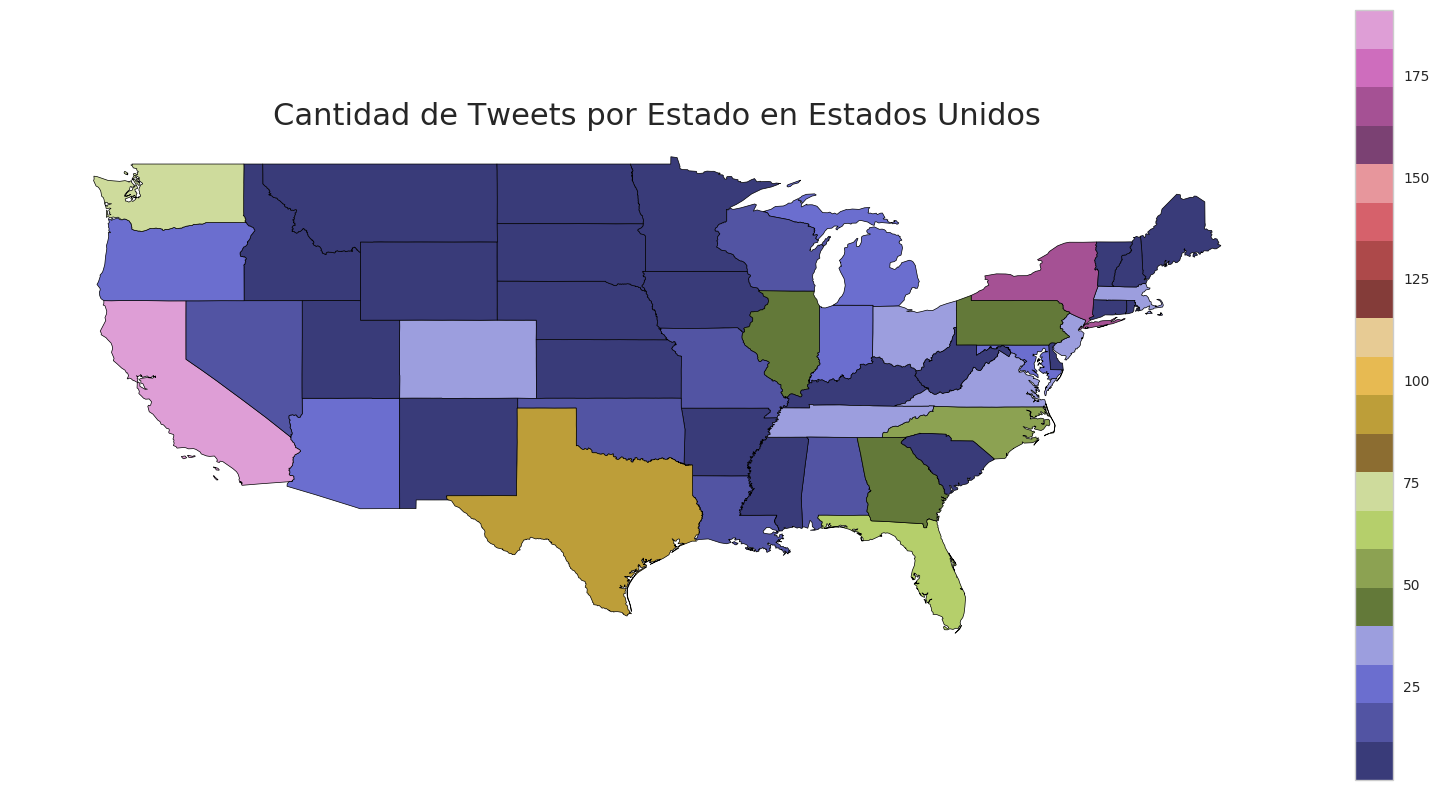

In [257]:
fig, grafico_cantidad_estados_usa_total = plt.subplots(1, figsize=(20, 10))
grafico_cantidad_estados_total=cantidad_estados_total.plot(column='Cantidad_total',cmap='tab20b', edgecolor='black',ax=grafico_cantidad_estados_usa_total,legend=True,figsize=(30,30),linewidth=0.5)
grafico_cantidad_estados_usa_total.axis('off')
grafico_cantidad_estados_usa_total.set_title("Cantidad de Tweets por Estado en Estados Unidos",fontsize=22)

Text(0.5,1,'Promedio de Tweets Reales por Estado en Estados Unidos')

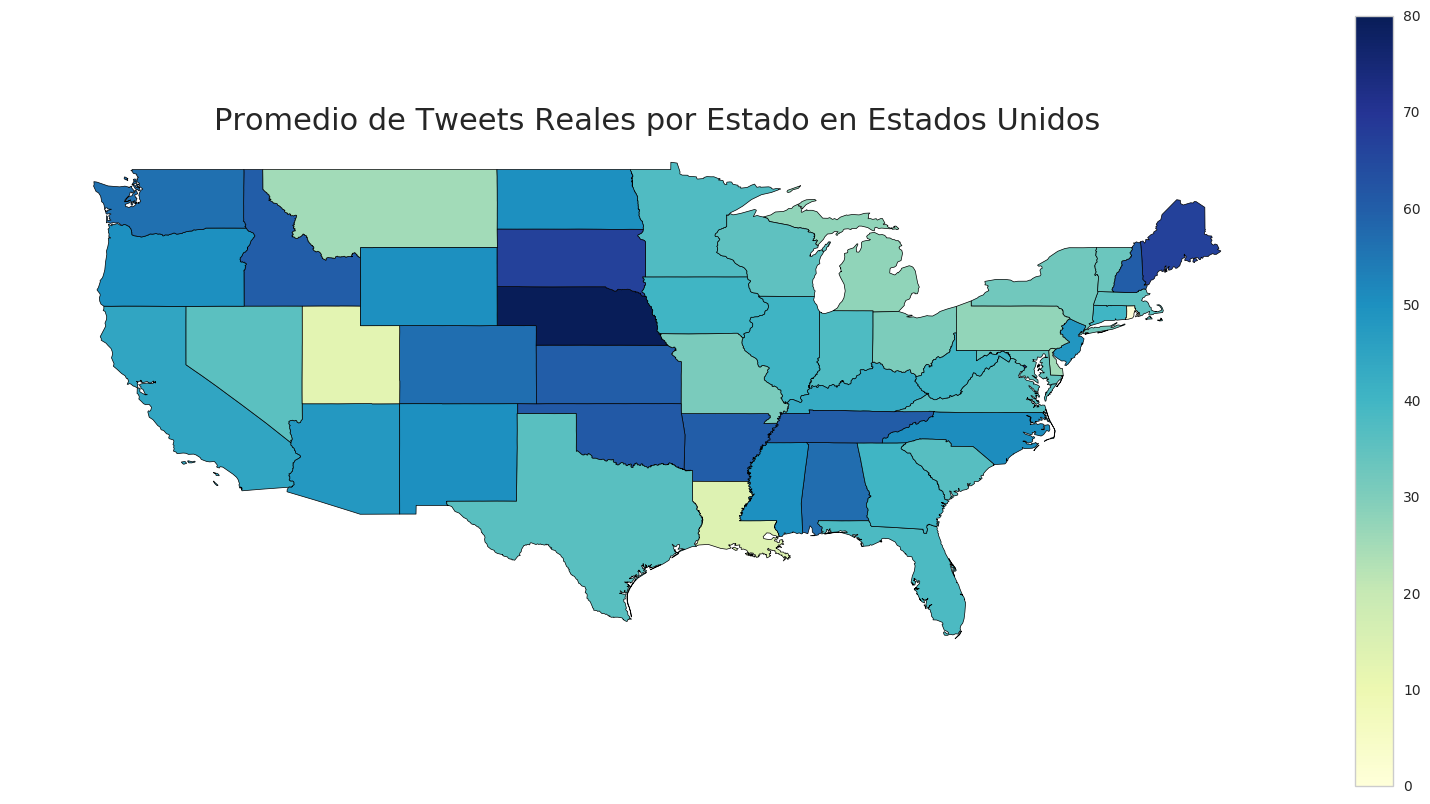

In [258]:
fig, grafico_promedio_estados_usa_real = plt.subplots(1, figsize=(20, 10))
grafico_promedio_real_estados=cantidad_estados_total.plot(column='Promedio_real',cmap='YlGnBu', edgecolor='black',ax=grafico_promedio_estados_usa_real,legend=True,figsize=(30,30),linewidth=0.5)
grafico_promedio_estados_usa_real.axis('off')
grafico_promedio_estados_usa_real.set_title("Promedio de Tweets Reales por Estado en Estados Unidos",fontsize=22)

Text(0.5,1,'Promedio de Tweets Falsos por Estado en Estados Unidos')

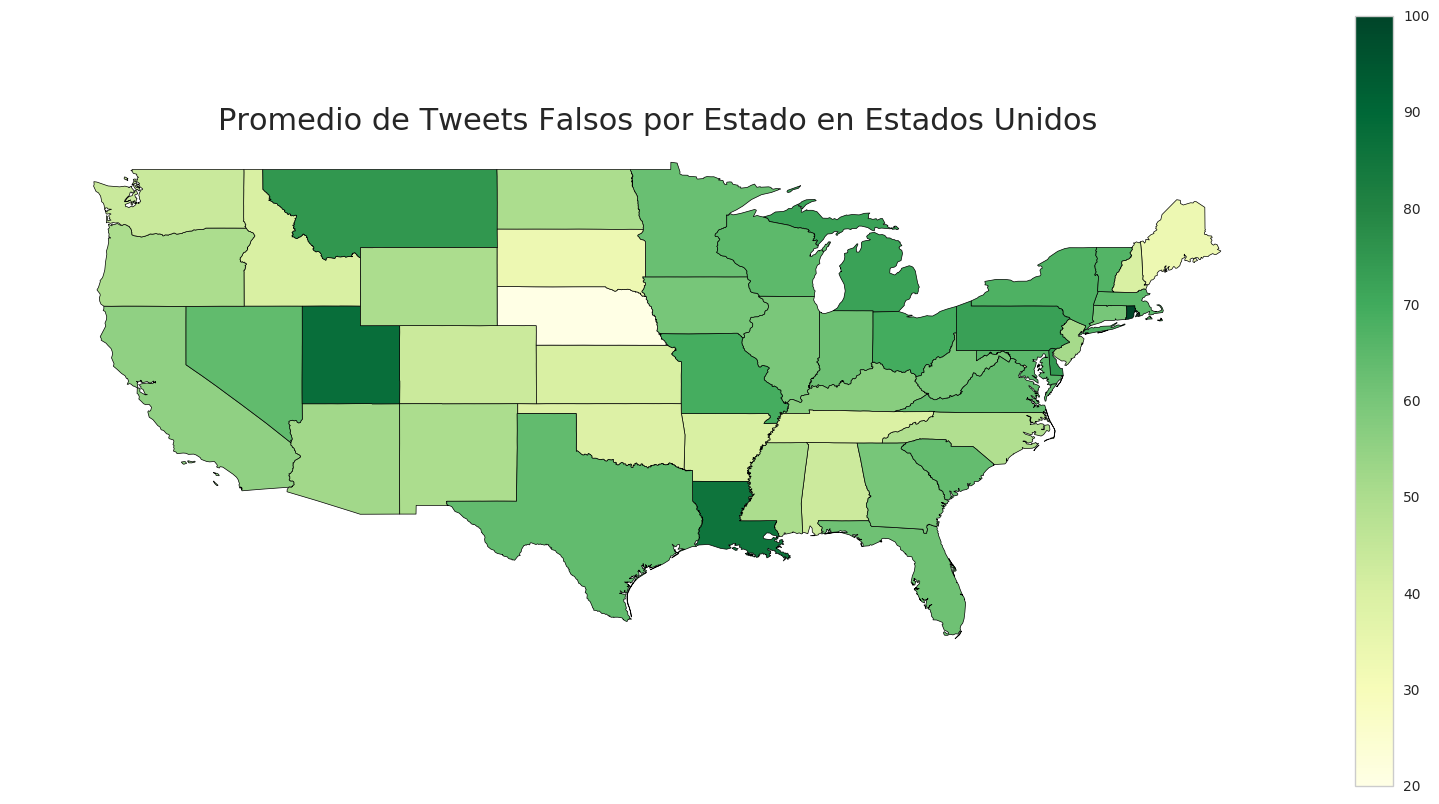

In [259]:
fig, grafico_promedio_estados_usa_falso = plt.subplots(1, figsize=(20, 10))
grafico_promedio_falso_estados=cantidad_estados_total.plot(column='Promedio_falso',cmap='YlGn', edgecolor='black',ax=grafico_promedio_estados_usa_falso,legend=True,figsize=(30,30),linewidth=0.5)
grafico_promedio_estados_usa_falso.axis('off')
grafico_promedio_estados_usa_falso.set_title("Promedio de Tweets Falsos por Estado en Estados Unidos",fontsize=22)

## 3) Cuentas arrobadas

In [198]:
arroba=tweets.copy()
arroba=arroba[(arroba['Tiene_arroba']==True)]
arroba=pd.concat([arroba, arroba['text'].str.split('@', expand=True)], axis=1)
arroba.drop(columns={0},inplace=True)
arroba.rename(columns={1:'Primero',2:'Segundo',3:'Tercero',4:'Cuarto',5:'Quinto',6:'Sexto',7:'Septimo',8:'Octavo'},inplace=True)
arroba.head()

,id,keyword,location,text,target,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,Primero,Segundo,Tercero,Cuarto,Quinto,Sexto,Septimo,Octavo
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,True,False,False,False,False,bbcmtd Wholesale Markets ablaze http://t.co/lH...,None,None,None,None,None,None,None
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0,True,True,False,False,False,PhDSquares #mufc they've built so much hype ar...,None,None,None,None,None,None,None
43,63,ablaze,NaN,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0,True,False,True,False,False,southridgelife,None,None,None,None,None,None,None
54,78,ablaze,Abuja,Noches El-Bestia '@Alexis_Sanchez: happy to se...,0,True,False,True,False,False,Alexis_Sanchez: happy to see my teammates and ...,None,None,None,None,None,None,None
57,81,ablaze,"Sao Paulo, Brazil",Set our hearts ablaze and every city was a gif...,0,True,False,False,False,True,Û_ https://t.co/cYoMPZ1A0Z,None,None,None,None,None,None,None


In [199]:
arroba_primero=arroba[['Primero','target']].copy()
arroba_primero['Primero']=arroba_primero['Primero'].str.capitalize()
arroba_primero=pd.concat([arroba_primero, arroba_primero['Primero'].str.split(' ', expand=True)], axis=1)
arroba_primero.rename(columns={0:'Mencion'},inplace=True)
arroba_primero=arroba_primero[['Mencion','target']]
arroba_primero=arroba_primero[(arroba_primero['Mencion']!='')]
arroba_primero_real=arroba_primero[(arroba_primero['target']==1)]
arroba_primero_falso=arroba_primero[(arroba_primero['target']==0)]
menciones_primero=arroba_primero['Mencion'].value_counts().reset_index()
menciones_primero_real=arroba_primero_real['Mencion'].value_counts().reset_index()
menciones_primero_falso=arroba_primero_falso['Mencion'].value_counts().reset_index()
menciones_primero.rename(columns={'index':'Mencion','Mencion':'Cantidad_primero_total'},inplace=True)
menciones_primero_real.rename(columns={'index':'Mencion','Mencion':'Cantidad_primero_real'},inplace=True)
menciones_primero_falso.rename(columns={'index':'Mencion','Mencion':'Cantidad_primero_falso'},inplace=True)
menciones_primero_total=pd.merge(menciones_primero,menciones_primero_real,on='Mencion',how='left')
menciones_primero_total=pd.merge(menciones_primero_total,menciones_primero_falso,on='Mencion',how='left')
menciones_primero_total.fillna(0,inplace=True)
menciones_primero_total.head()

,Mencion,Cantidad_primero_total,Cantidad_primero_real,Cantidad_primero_falso
0,Youtube,81,18.0,63.0
1,Change,9,4.0,5.0
2,Emmerdale,7,1.0,6.0
3,Arianagrande,7,0.0,7.0
4,Usatoday,7,4.0,3.0


In [200]:
arroba_segundo=arroba[['Segundo','target']].copy()
arroba_segundo['Segundo']=arroba_segundo['Segundo'].str.capitalize()
arroba_segundo=pd.concat([arroba_segundo, arroba_segundo['Segundo'].str.split(' ', expand=True)], axis=1)
arroba_segundo.rename(columns={0:'Mencion'},inplace=True)
arroba_segundo=arroba_segundo[['Mencion','target']]
arroba_segundo=arroba_segundo[(arroba_segundo['Mencion']!='')]
arroba_segundo_real=arroba_segundo[(arroba_segundo['target']==1)]
arroba_segundo_falso=arroba_segundo[(arroba_segundo['target']==0)]
menciones_segundo=arroba_segundo['Mencion'].value_counts().reset_index()
menciones_segundo_real=arroba_segundo_real['Mencion'].value_counts().reset_index()
menciones_segundo_falso=arroba_segundo_falso['Mencion'].value_counts().reset_index()
menciones_segundo.rename(columns={'index':'Mencion','Mencion':'Cantidad_segundo_total'},inplace=True)
menciones_segundo_real.rename(columns={'index':'Mencion','Mencion':'Cantidad_segundo_real'},inplace=True)
menciones_segundo_falso.rename(columns={'index':'Mencion','Mencion':'Cantidad_segundo_falso'},inplace=True)
menciones_segundo_total=pd.merge(menciones_segundo,menciones_segundo_real,on='Mencion',how='left')
menciones_segundo_total=pd.merge(menciones_segundo_total,menciones_segundo_falso,on='Mencion',how='left')
menciones_segundo_total.fillna(0,inplace=True)
menciones_segundo_total.head()

,Mencion,Cantidad_segundo_total,Cantidad_segundo_real,Cantidad_segundo_falso
0,Diamondkesawn,4,0.0,4.0
1,Usagov,4,4.0,0.0
2,Arianagrande,4,0.0,4.0
3,Foxnews,3,3.0,0.0
4,Gerenciatodos,3,1.0,2.0


In [201]:
arroba_tercero=arroba[['Tercero','target']].copy()
arroba_tercero['Tercero']=arroba_tercero['Tercero'].str.capitalize()
arroba_tercero=pd.concat([arroba_tercero, arroba_tercero['Tercero'].str.split(' ', expand=True)], axis=1)
arroba_tercero.rename(columns={0:'Mencion'},inplace=True)
arroba_tercero=arroba_tercero[['Mencion','target']]
arroba_tercero=arroba_tercero[(arroba_tercero['Mencion']!='')]
arroba_tercero_real=arroba_tercero[(arroba_tercero['target']==1)]
arroba_tercero_falso=arroba_tercero[(arroba_tercero['target']==0)]
menciones_tercero=arroba_tercero['Mencion'].value_counts().reset_index()
menciones_tercero_real=arroba_tercero_real['Mencion'].value_counts().reset_index()
menciones_tercero_falso=arroba_tercero_falso['Mencion'].value_counts().reset_index()
menciones_tercero.rename(columns={'index':'Mencion','Mencion':'Cantidad_tercero_total'},inplace=True)
menciones_tercero_real.rename(columns={'index':'Mencion','Mencion':'Cantidad_tercero_real'},inplace=True)
menciones_tercero_falso.rename(columns={'index':'Mencion','Mencion':'Cantidad_tercero_falso'},inplace=True)
menciones_tercero_total=pd.merge(menciones_tercero,menciones_tercero_real,on='Mencion',how='left')
menciones_tercero_total=pd.merge(menciones_tercero_total,menciones_tercero_falso,on='Mencion',how='left')
menciones_tercero_total.fillna(0,inplace=True)
menciones_tercero_total.head()

,Mencion,Cantidad_tercero_total,Cantidad_tercero_real,Cantidad_tercero_falso
0,Realmandyrain,3,0.0,3.0
1,Claytonbryant,3,0.0,3.0
2,Stretcher,2,0.0,2.0
3,Refugees,2,1.0,1.0
4,Juliedicaro,2,0.0,2.0


In [202]:
arroba_cuarto=arroba[['Cuarto','target']].copy()
arroba_cuarto['Cuarto']=arroba_cuarto['Cuarto'].str.capitalize()
arroba_cuarto=pd.concat([arroba_cuarto, arroba_cuarto['Cuarto'].str.split(' ', expand=True)], axis=1)
arroba_cuarto.rename(columns={0:'Mencion'},inplace=True)
arroba_cuarto=arroba_cuarto[['Mencion','target']]
arroba_cuarto=arroba_cuarto[(arroba_cuarto['Mencion']!='')]
arroba_cuarto_real=arroba_cuarto[(arroba_cuarto['target']==1)]
arroba_cuarto_falso=arroba_cuarto[(arroba_cuarto['target']==0)]
menciones_cuarto=arroba_cuarto['Mencion'].value_counts().reset_index()
menciones_cuarto_real=arroba_cuarto_real['Mencion'].value_counts().reset_index()
menciones_cuarto_falso=arroba_cuarto_falso['Mencion'].value_counts().reset_index()
menciones_cuarto.rename(columns={'index':'Mencion','Mencion':'Cantidad_cuarto_total'},inplace=True)
menciones_cuarto_real.rename(columns={'index':'Mencion','Mencion':'Cantidad_cuarto_real'},inplace=True)
menciones_cuarto_falso.rename(columns={'index':'Mencion','Mencion':'Cantidad_cuarto_falso'},inplace=True)
menciones_cuarto_total=pd.merge(menciones_cuarto,menciones_cuarto_real,on='Mencion',how='left')
menciones_cuarto_total=pd.merge(menciones_cuarto_total,menciones_cuarto_falso,on='Mencion',how='left')
menciones_cuarto_total.fillna(0,inplace=True)
menciones_cuarto_total.head()

,Mencion,Cantidad_cuarto_total,Cantidad_cuarto_real,Cantidad_cuarto_falso
0,Itunesmusic,3,0.0,3.0
1,Towel,2,1.0,1.0
2,Rexyy,2,0.0,2.0
3,Jdabe80,2,0.0,2.0
4,Charstevens97,1,1.0,0.0


In [203]:
arroba_quinto=arroba[['Quinto','target']].copy()
arroba_quinto['Quinto']=arroba_quinto['Quinto'].str.capitalize()
arroba_quinto=pd.concat([arroba_quinto, arroba_quinto['Quinto'].str.split(' ', expand=True)], axis=1)
arroba_quinto.rename(columns={0:'Mencion'},inplace=True)
arroba_quinto=arroba_quinto[['Mencion','target']]
arroba_quinto=arroba_quinto[(arroba_quinto['Mencion']!='')]
arroba_quinto_real=arroba_quinto[(arroba_quinto['target']==1)]
arroba_quinto_falso=arroba_quinto[(arroba_quinto['target']==0)]
menciones_quinto=arroba_quinto['Mencion'].value_counts().reset_index()
menciones_quinto_real=arroba_quinto_real['Mencion'].value_counts().reset_index()
menciones_quinto_falso=arroba_quinto_falso['Mencion'].value_counts().reset_index()
menciones_quinto.rename(columns={'index':'Mencion','Mencion':'Cantidad_quinto_total'},inplace=True)
menciones_quinto_real.rename(columns={'index':'Mencion','Mencion':'Cantidad_quinto_real'},inplace=True)
menciones_quinto_falso.rename(columns={'index':'Mencion','Mencion':'Cantidad_quinto_falso'},inplace=True)
menciones_quinto_total=pd.merge(menciones_quinto,menciones_quinto_real,on='Mencion',how='left')
menciones_quinto_total=pd.merge(menciones_quinto_total,menciones_quinto_falso,on='Mencion',how='left')
menciones_quinto_total.fillna(0,inplace=True)
menciones_quinto_total.head()

,Mencion,Cantidad_quinto_total,Cantidad_quinto_real,Cantidad_quinto_falso
0,Itunes,3,0.0,3.0
1,Towel,2,0.0,2.0
2,Benjbeckwith,1,1.0,0.0
3,Cumtown\n,1,0.0,1.0
4,Rt_america,1,0.0,1.0


In [204]:
arroba_sexto=arroba[['Sexto','target']].copy()
arroba_sexto['Sexto']=arroba_sexto['Sexto'].str.capitalize()
arroba_sexto=pd.concat([arroba_sexto, arroba_sexto['Sexto'].str.split(' ', expand=True)], axis=1)
arroba_sexto.rename(columns={0:'Mencion'},inplace=True)
arroba_sexto=arroba_sexto[['Mencion','target']]
arroba_sexto=arroba_sexto[(arroba_sexto['Mencion']!='')]
arroba_sexto_real=arroba_sexto[(arroba_sexto['target']==1)]
arroba_sexto_falso=arroba_sexto[(arroba_sexto['target']==0)]
menciones_sexto=arroba_sexto['Mencion'].value_counts().reset_index()
menciones_sexto_real=arroba_sexto_real['Mencion'].value_counts().reset_index()
menciones_sexto_falso=arroba_sexto_falso['Mencion'].value_counts().reset_index()
menciones_sexto.rename(columns={'index':'Mencion','Mencion':'Cantidad_sexto_total'},inplace=True)
menciones_sexto_real.rename(columns={'index':'Mencion','Mencion':'Cantidad_sexto_real'},inplace=True)
menciones_sexto_falso.rename(columns={'index':'Mencion','Mencion':'Cantidad_sexto_falso'},inplace=True)
menciones_sexto_total=pd.merge(menciones_sexto,menciones_sexto_real,on='Mencion',how='left')
menciones_sexto_total=pd.merge(menciones_sexto_total,menciones_sexto_falso,on='Mencion',how='left')
menciones_sexto_total.fillna(0,inplace=True)
menciones_sexto_total.head()

,Mencion,Cantidad_sexto_total,Cantidad_sexto_real,Cantidad_sexto_falso
0,Hughes1128,1,0.0,1
1,Iamtonyneal,1,0.0,1
2,Aftershock_org,1,0.0,1
3,Towel,1,0.0,1
4,Bj_nutt\n,1,0.0,1


In [205]:
arroba_septimo=arroba[['Septimo','target']].copy()
arroba_septimo['Septimo']=arroba_septimo['Septimo'].str.capitalize()
arroba_septimo=pd.concat([arroba_septimo, arroba_septimo['Septimo'].str.split(' ', expand=True)], axis=1)
arroba_septimo.rename(columns={0:'Mencion'},inplace=True)
arroba_septimo=arroba_septimo[['Mencion','target']]
arroba_septimo=arroba_septimo[(arroba_septimo['Mencion']!='')]
arroba_septimo_real=arroba_septimo[(arroba_septimo['target']==1)]
arroba_septimo_falso=arroba_septimo[(arroba_septimo['target']==0)]
menciones_septimo=arroba_septimo['Mencion'].value_counts().reset_index()
menciones_septimo_real=arroba_septimo_real['Mencion'].value_counts().reset_index()
menciones_septimo_falso=arroba_septimo_falso['Mencion'].value_counts().reset_index()
menciones_septimo.rename(columns={'index':'Mencion','Mencion':'Cantidad_septimo_total'},inplace=True)
menciones_septimo_real.rename(columns={'index':'Mencion','Mencion':'Cantidad_septimo_real'},inplace=True)
menciones_septimo_falso.rename(columns={'index':'Mencion','Mencion':'Cantidad_septimo_falso'},inplace=True)
menciones_septimo_total=pd.merge(menciones_septimo,menciones_septimo_real,on='Mencion',how='left')
menciones_septimo_total=pd.merge(menciones_septimo_total,menciones_septimo_falso,on='Mencion',how='left')
menciones_septimo_total.fillna(0,inplace=True)
menciones_septimo_total.head()

,Mencion,Cantidad_septimo_total,Cantidad_septimo_real,Cantidad_septimo_falso
0,Cumslut_2\n,1,0.0,1
1,Lopezandthelion,1,0.0,1


In [206]:
arroba_octavo=arroba[['Octavo','target']].copy()
arroba_octavo['Octavo']=arroba_octavo['Octavo'].str.capitalize()
arroba_octavo=pd.concat([arroba_octavo, arroba_octavo['Octavo'].str.split(' ', expand=True)], axis=1)
arroba_octavo.rename(columns={0:'Mencion'},inplace=True)
arroba_octavo=arroba_octavo[['Mencion','target']]
arroba_octavo=arroba_octavo[(arroba_octavo['Mencion']!='')]
arroba_octavo_real=arroba_octavo[(arroba_octavo['target']==1)]
arroba_octavo_falso=arroba_octavo[(arroba_octavo['target']==0)]
menciones_octavo=arroba_octavo['Mencion'].value_counts().reset_index()
menciones_octavo_real=arroba_octavo_real['Mencion'].value_counts().reset_index()
menciones_octavo_falso=arroba_octavo_falso['Mencion'].value_counts().reset_index()
menciones_octavo.rename(columns={'index':'Mencion','Mencion':'Cantidad_octavo_total'},inplace=True)
menciones_octavo_real.rename(columns={'index':'Mencion','Mencion':'Cantidad_octavo_real'},inplace=True)
menciones_octavo_falso.rename(columns={'index':'Mencion','Mencion':'Cantidad_octavo_falso'},inplace=True)
menciones_octavo_total=pd.merge(menciones_octavo,menciones_octavo_real,on='Mencion',how='left')
menciones_octavo_total=pd.merge(menciones_octavo_total,menciones_octavo_falso,on='Mencion',how='left')
menciones_octavo_total.fillna(0,inplace=True)
menciones_octavo_total.head()

,Mencion,Cantidad_octavo_total,Cantidad_octavo_real,Cantidad_octavo_falso
0,Girlslovecum,1,0.0,1


In [207]:
arroba_cantidad_total=pd.merge(menciones_primero_total,menciones_segundo_total,on='Mencion',how='outer')
arroba_cantidad_total=pd.merge(arroba_cantidad_total,menciones_tercero_total,on='Mencion',how='outer')
arroba_cantidad_total=pd.merge(arroba_cantidad_total,menciones_cuarto_total,on='Mencion',how='outer')
arroba_cantidad_total=pd.merge(arroba_cantidad_total,menciones_quinto_total,on='Mencion',how='outer')
arroba_cantidad_total=pd.merge(arroba_cantidad_total,menciones_sexto_total,on='Mencion',how='outer')
arroba_cantidad_total=pd.merge(arroba_cantidad_total,menciones_septimo_total,on='Mencion',how='outer')
arroba_cantidad_total=pd.merge(arroba_cantidad_total,menciones_octavo_total,on='Mencion',how='outer')
arroba_cantidad_total.fillna(0,inplace=True)
arroba_cantidad_total['Cantidad_total']=arroba_cantidad_total['Cantidad_primero_total']+arroba_cantidad_total['Cantidad_segundo_total']+arroba_cantidad_total['Cantidad_tercero_total']+arroba_cantidad_total['Cantidad_cuarto_total']+arroba_cantidad_total['Cantidad_quinto_total']+arroba_cantidad_total['Cantidad_sexto_total']+arroba_cantidad_total['Cantidad_septimo_total']+arroba_cantidad_total['Cantidad_octavo_total']
arroba_cantidad_total['Cantidad_real']=arroba_cantidad_total['Cantidad_primero_real']+arroba_cantidad_total['Cantidad_segundo_real']+arroba_cantidad_total['Cantidad_tercero_real']+arroba_cantidad_total['Cantidad_cuarto_real']+arroba_cantidad_total['Cantidad_quinto_real']+arroba_cantidad_total['Cantidad_sexto_real']+arroba_cantidad_total['Cantidad_septimo_real']+arroba_cantidad_total['Cantidad_octavo_real']
arroba_cantidad_total['Cantidad_falso']=arroba_cantidad_total['Cantidad_primero_falso']+arroba_cantidad_total['Cantidad_segundo_falso']+arroba_cantidad_total['Cantidad_tercero_falso']+arroba_cantidad_total['Cantidad_cuarto_falso']+arroba_cantidad_total['Cantidad_quinto_falso']+arroba_cantidad_total['Cantidad_sexto_falso']+arroba_cantidad_total['Cantidad_septimo_falso']+arroba_cantidad_total['Cantidad_octavo_falso']
arroba_cantidad_total.drop(columns={'Cantidad_primero_total','Cantidad_segundo_total','Cantidad_tercero_total','Cantidad_cuarto_total','Cantidad_quinto_total','Cantidad_sexto_total','Cantidad_septimo_total','Cantidad_octavo_total'},inplace=True)
arroba_cantidad_total.drop(columns={'Cantidad_primero_real','Cantidad_segundo_real','Cantidad_tercero_real','Cantidad_cuarto_real','Cantidad_quinto_real','Cantidad_sexto_real','Cantidad_septimo_real','Cantidad_octavo_real'},inplace=True)
arroba_cantidad_total.drop(columns={'Cantidad_primero_falso','Cantidad_segundo_falso','Cantidad_tercero_falso','Cantidad_cuarto_falso','Cantidad_quinto_falso','Cantidad_sexto_falso','Cantidad_septimo_falso','Cantidad_octavo_falso'},inplace=True)
arroba_cantidad_total.sort_values(by=['Cantidad_total'],ascending=False,inplace=True)
arroba_cantidad_total['Real']=(arroba_cantidad_total['Cantidad_real']/arroba_cantidad_total['Cantidad_total'])*100
arroba_cantidad_total['Falso']=(arroba_cantidad_total['Cantidad_falso']/arroba_cantidad_total['Cantidad_total'])*100
arroba_cantidad_total.drop(columns={'Cantidad_real','Cantidad_falso'},inplace=True)
arroba_cantidad_total_top_10=arroba_cantidad_total.head(10)
arroba_promedio_top_10=arroba_cantidad_total_top_10[['Mencion','Real','Falso']]
arroba_cantidad_total_top_10=arroba_cantidad_total_top_10[['Mencion','Cantidad_total']]
arroba_cantidad_total_top_10.set_index('Mencion',inplace=True)
arroba_promedio_top_10.set_index('Mencion',inplace=True)
arroba_cantidad_total_top_10

,Cantidad_total
Mencion,
Youtube,83.0
Arianagrande,11.0
Potus,9.0
Foxnews,9.0
Change,9.0
Emmerdale,8.0
Usatoday,8.0
Djicemoon,7.0
Justinbieber,7.0


Text(0,0.5,'Cuentas')

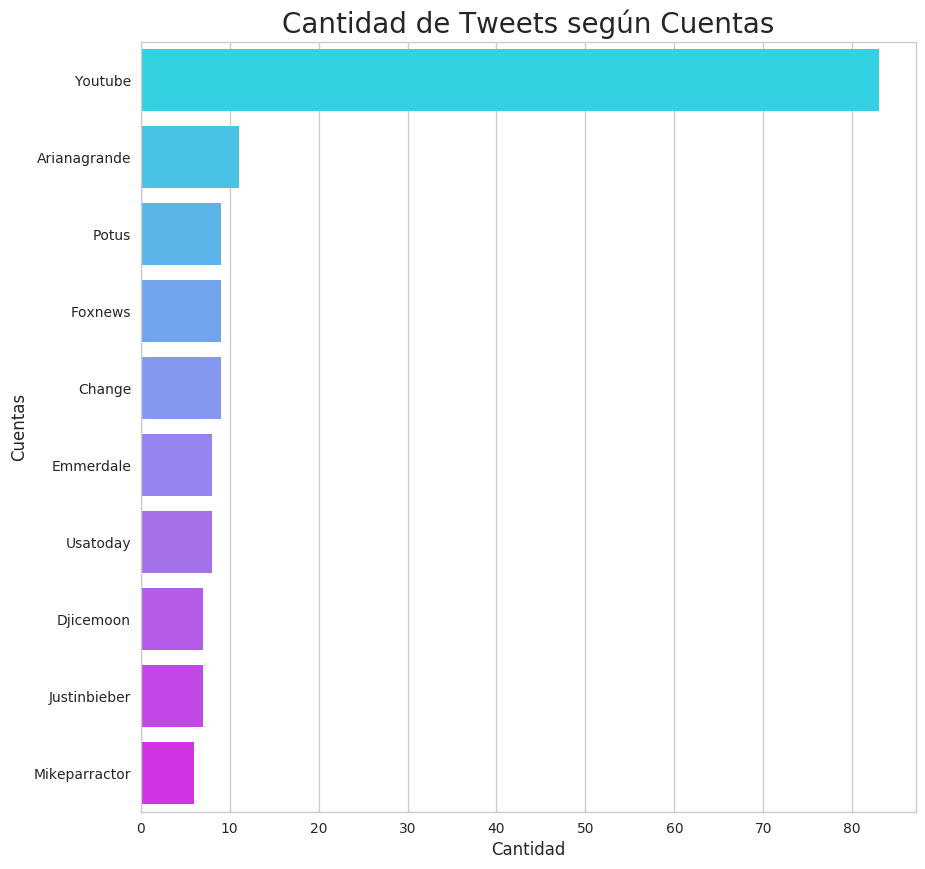

In [262]:
plt.subplots(figsize=(10,10))
grafico_cantidad_menciones=sns.barplot(x=arroba_cantidad_total_top_10['Cantidad_total'],y=arroba_cantidad_total_top_10.index,orient='h',palette='cool')
grafico_cantidad_menciones.set_title("Cantidad de Tweets según Cuentas",fontsize=20)
grafico_cantidad_menciones.set_xlabel("Cantidad",fontsize=12)
grafico_cantidad_menciones.set_ylabel("Cuentas",fontsize=12)

Text(95.7222,0.5,'Cuentas')

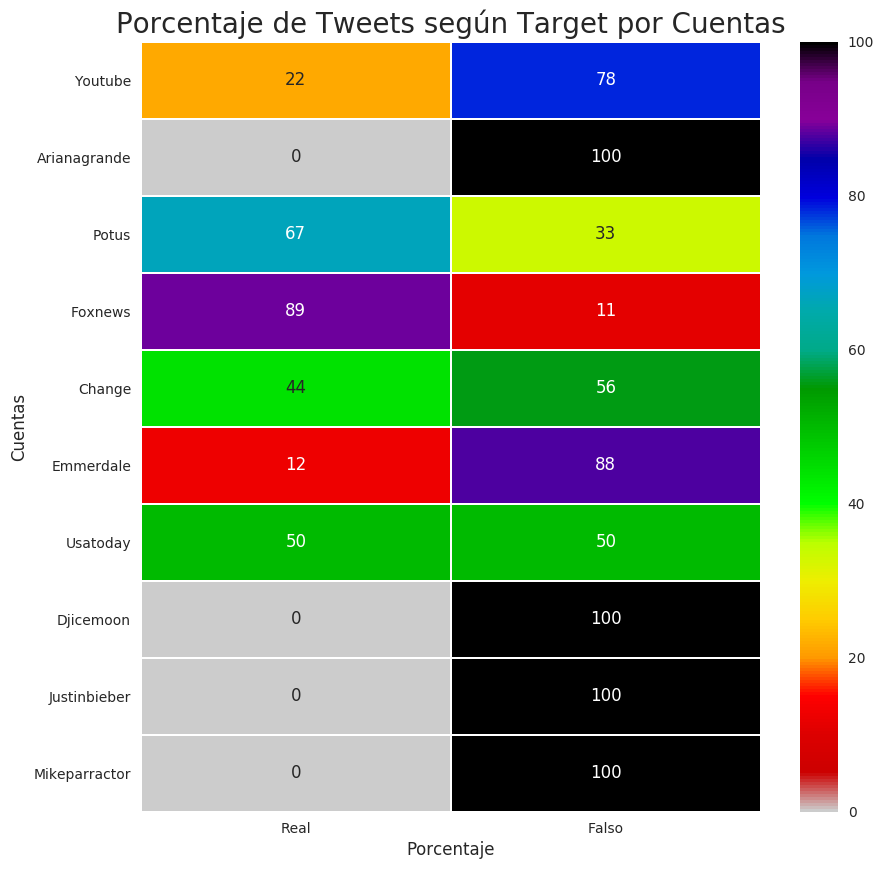

In [263]:
plt.subplots(figsize=(10,10))
grafico_arroba_promedio_top_10=sns.heatmap(arroba_promedio_top_10,linewidths=.5,fmt=".0f",annot=True,cmap="nipy_spectral_r")
grafico_arroba_promedio_top_10.set_title("Porcentaje de Tweets según Target por Cuentas",fontsize=20)
grafico_arroba_promedio_top_10.set_xlabel("Porcentaje",fontsize=12)
grafico_arroba_promedio_top_10.set_ylabel("Cuentas",fontsize=12)

## 4) Idioma

In [210]:
tweets['ISO_639-1']=tweets['text'].apply(lambda x: lng(x))
tweets.head()

,id,keyword,location,text,target,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,ISO_639-1
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,False,True,False,False,False,en
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,False,False,False,False,False,en
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,False,False,False,False,False,en
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,False,True,False,False,False,en
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,False,True,False,False,False,en


In [211]:
idioma_real=tweets[(tweets['target']==1)]
idioma_falso=tweets[(tweets['target']==0)]
idioma_total=tweets['ISO_639-1'].value_counts().reset_index()
idioma_real=idioma_real['ISO_639-1'].value_counts().reset_index()
idioma_falso=idioma_falso['ISO_639-1'].value_counts().reset_index()
idioma_total.rename(columns={'index':'ISO_639-1','ISO_639-1':'Cantidad_total'},inplace=True)
idioma_real.rename(columns={'index':'ISO_639-1','ISO_639-1':'Cantidad_real'},inplace=True)
idioma_falso.rename(columns={'index':'ISO_639-1','ISO_639-1':'Cantidad_falso'},inplace=True)
idioma_cantidad_total=pd.merge(idioma_total,idioma_real,on='ISO_639-1',how='left')
idioma_cantidad_total=pd.merge(idioma_cantidad_total,idioma_falso,on='ISO_639-1',how='left')
idioma_cantidad_total=pd.merge(idioma_cantidad_total,idiomas,on='ISO_639-1',how='left')
idioma_cantidad_total.fillna(0,inplace=True)
idioma_cantidad_total.sort_values(by=['Cantidad_total'],ascending=False,inplace=True)
idioma_cantidad_total['Falso']=(idioma_cantidad_total['Cantidad_falso']/idioma_cantidad_total['Cantidad_total'])*100
idioma_cantidad_total['Real']=(idioma_cantidad_total['Cantidad_real']/idioma_cantidad_total['Cantidad_total'])*100
idioma_cantidad_total.drop(columns={'Cantidad_real','Cantidad_falso'},inplace=True)
idioma_cantidad_top_10=idioma_cantidad_total.head(10)
idioma_cantidad_top_10_total=idioma_cantidad_top_10[['nombre','Cantidad_total']]
idioma_cantidad_top_10_porcentaje=idioma_cantidad_top_10[['nombre','Falso','Real']]
idioma_cantidad_top_10_total.set_index('nombre',inplace=True)
idioma_cantidad_top_10_porcentaje.set_index('nombre',inplace=True)
idioma_cantidad_top_10_total

,Cantidad_total
nombre,
Inglés,7311
Alemán,59
Catalán,25
Danés,21
Francés,20
Noruego,18
Italiano,18
Holandés,17
Afrikáans,15


Text(0,0.5,'Idioma')

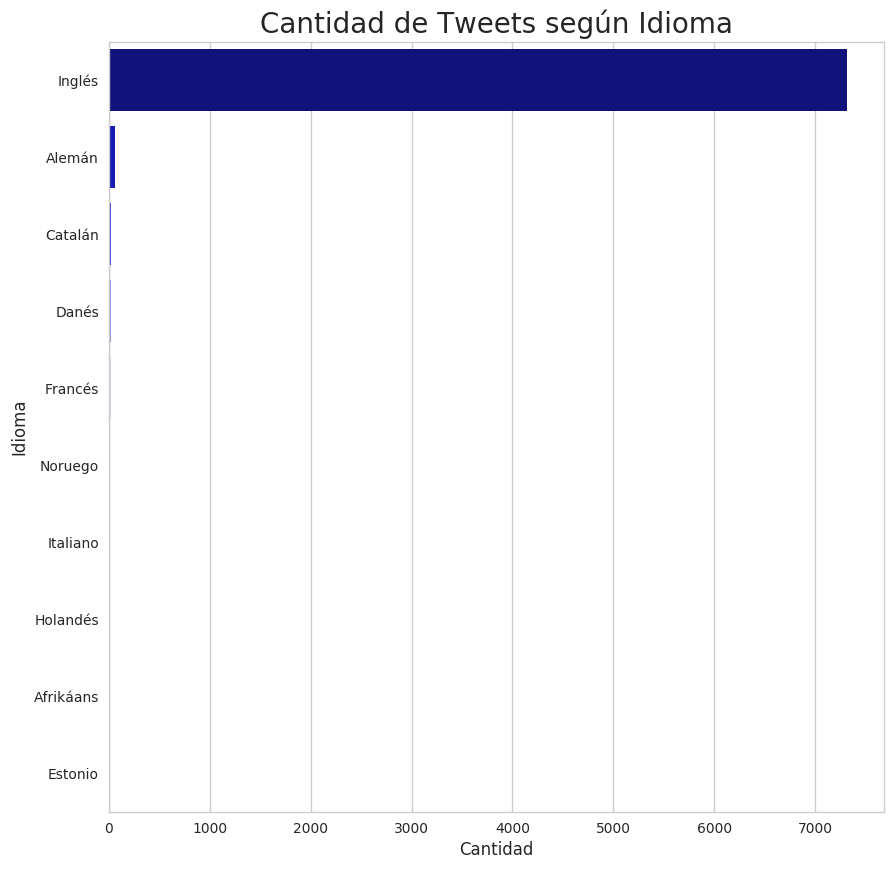

In [264]:
plt.subplots(figsize=(10,10))
grafico_idioma_cantidad_top_10_total=sns.barplot(x=idioma_cantidad_top_10_total['Cantidad_total'],y=idioma_cantidad_top_10_total.index,orient='h',palette='seismic')
grafico_idioma_cantidad_top_10_total.set_title("Cantidad de Tweets según Idioma",fontsize=20)
grafico_idioma_cantidad_top_10_total.set_xlabel("Cantidad",fontsize=12)
grafico_idioma_cantidad_top_10_total.set_ylabel("Idioma",fontsize=12)

[Text(0,0.5,'Inglés'),
 Text(0,1.5,'Alemán'),
 Text(0,2.5,'Catalán'),
 Text(0,3.5,'Danés'),
 Text(0,4.5,'Francés'),
 Text(0,5.5,'Noruego'),
 Text(0,6.5,'Italiano'),
 Text(0,7.5,'Holandés'),
 Text(0,8.5,'Afrikáans'),
 Text(0,9.5,'Estonio')]

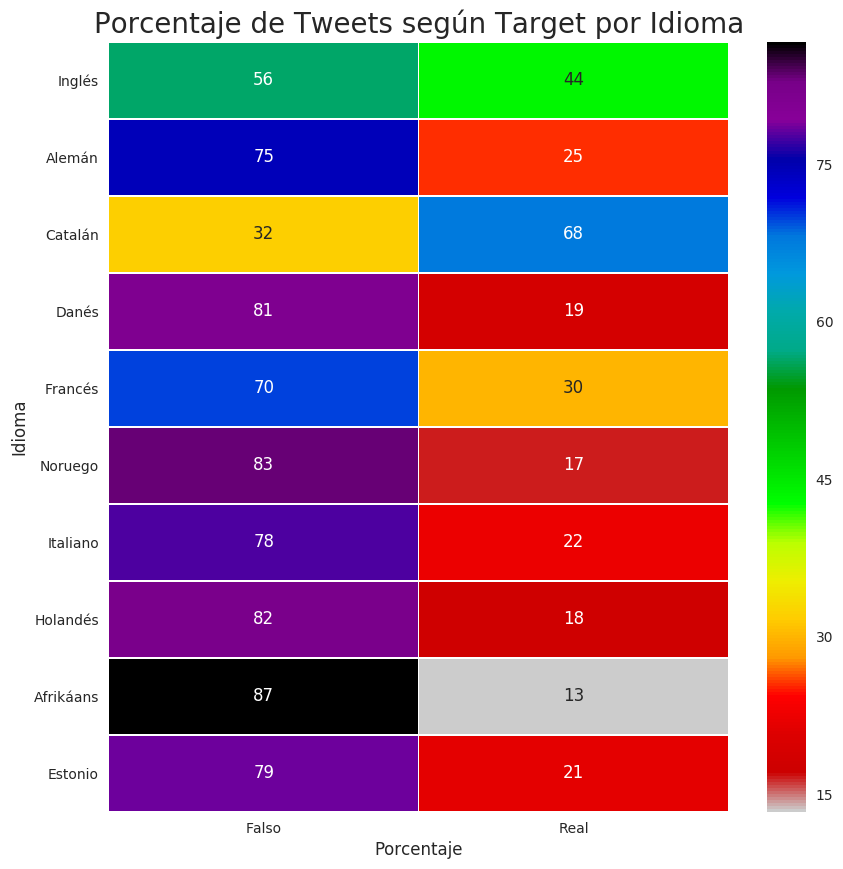

In [265]:
plt.subplots(figsize=(10,10))
grafico_idioma_cantidad_top_10_porcentaje=sns.heatmap(idioma_cantidad_top_10_porcentaje,linewidths=.5,fmt=".0f",annot=True,cmap="nipy_spectral_r")
grafico_idioma_cantidad_top_10_porcentaje.set_title("Porcentaje de Tweets según Target por Idioma",fontsize=20)
grafico_idioma_cantidad_top_10_porcentaje.set_xlabel("Porcentaje",fontsize=12)
grafico_idioma_cantidad_top_10_porcentaje.set_ylabel("Idioma",fontsize=12)
grafico_idioma_cantidad_top_10_porcentaje.set_yticklabels(grafico_idioma_cantidad_top_10_porcentaje.get_yticklabels(),rotation=0)

## 4) Hashtags

In [214]:
hashtag=tweets.copy()
hashtag=hashtag[(hashtag['Tiene_hashtag']==True)]
hashtag=pd.concat([hashtag, hashtag['text'].str.split('#', expand=True)], axis=1)
hashtag.drop(columns={0},inplace=True)
hashtag.rename(columns={1:'Primero',2:'Segundo',3:'Tercero',4:'Cuarto',5:'Quinto',6:'Sexto',7:'Septimo',8:'Octavo',9:'Noveno',10:'Decimo',11:'Decimoprimero',12:'Decimosegundo',13:'Decimotercero'},inplace=True)
hashtag.head()

,id,keyword,location,text,target,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,...,Cuarto,Quinto,Sexto,Septimo,Octavo,Noveno,Decimo,Decimoprimero,Decimosegundo,Decimotercero
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,False,True,False,False,False,...,None,None,None,None,None,None,None,None,None,None
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,False,True,False,False,False,...,None,None,None,None,None,None,None,None,None,None
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,False,True,False,False,False,...,None,None,None,None,None,None,None,None,None,None
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,False,True,False,False,False,...,None,None,None,None,None,None,None,None,None,None
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,False,True,False,False,False,...,None,None,None,None,None,None,None,None,None,None


In [215]:
hashtag_primero=hashtag[['Primero','target']].copy()
hashtag_primero['Primero']=hashtag['Primero'].str.capitalize()
hashtag_primero=pd.concat([hashtag_primero, hashtag_primero['Primero'].str.split(' ', expand=True)], axis=1)
hashtag_primero.rename(columns={0:'Hashtag'},inplace=True)
hashtag_primero=hashtag_primero[['Hashtag','target']]
hashtag_primero=hashtag_primero[(hashtag_primero['Hashtag']!='')]
hashtag_primero_real=hashtag_primero[(hashtag_primero['target']==1)]
hashtag_primero_falso=hashtag_primero[(hashtag_primero['target']==0)]
hashtag_cantidad_primero=hashtag_primero['Hashtag'].value_counts().reset_index()
hashtag_cantidad_primero_real=hashtag_primero_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_primero_falso=hashtag_primero_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_primero.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_primero_total'},inplace=True)
hashtag_cantidad_primero_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_primero_real'},inplace=True)
hashtag_cantidad_primero_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_primero_falso'},inplace=True)
hashtag_cantidad_primero_total=pd.merge(hashtag_cantidad_primero,hashtag_cantidad_primero_real,on='Hashtag',how='left')
hashtag_cantidad_primero_total=pd.merge(hashtag_cantidad_primero_total,hashtag_cantidad_primero_falso,on='Hashtag',how='left')
hashtag_cantidad_primero_total.fillna(0,inplace=True)
hashtag_cantidad_primero_total.head()

,Hashtag,Cantidad_primero_total,Cantidad_primero_real,Cantidad_primero_falso
0,Hot,31,13.0,18.0
1,News,29,23.0,6.0
2,Earthquake,19,19.0,0.0
3,Nowplaying,18,1.0,17.0
4,Hiroshima,16,16.0,0.0


In [216]:
hashtag_segundo=hashtag[['Segundo','target']].copy()
hashtag_segundo['Segundo']=hashtag['Segundo'].str.capitalize()
hashtag_segundo=pd.concat([hashtag_segundo, hashtag_segundo['Segundo'].str.split(' ', expand=True)], axis=1)
hashtag_segundo.rename(columns={0:'Hashtag'},inplace=True)
hashtag_segundo=hashtag_segundo[['Hashtag','target']]
hashtag_segundo=hashtag_segundo[(hashtag_segundo['Hashtag']!='')]
hashtag_segundo_real=hashtag_segundo[(hashtag_segundo['target']==1)]
hashtag_segundo_falso=hashtag_segundo[(hashtag_segundo['target']==0)]
hashtag_cantidad_segundo=hashtag_segundo['Hashtag'].value_counts().reset_index()
hashtag_cantidad_segundo_real=hashtag_segundo_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_segundo_falso=hashtag_segundo_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_segundo.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_segundo_total'},inplace=True)
hashtag_cantidad_segundo_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_segundo_real'},inplace=True)
hashtag_cantidad_segundo_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_segundo_falso'},inplace=True)
hashtag_cantidad_segundo_total=pd.merge(hashtag_cantidad_segundo,hashtag_cantidad_segundo_real,on='Hashtag',how='left')
hashtag_cantidad_segundo_total=pd.merge(hashtag_cantidad_segundo_total,hashtag_cantidad_segundo_falso,on='Hashtag',how='left')
hashtag_cantidad_segundo_total.fillna(0,inplace=True)
hashtag_cantidad_segundo_total.head()

,Hashtag,Cantidad_segundo_total,Cantidad_segundo_real,Cantidad_segundo_falso
0,News,32,23.0,9.0
1,Prebreak,30,13.0,17.0
2,Islam,9,3.0,6.0
3,??,7,7.0,0.0
4,Trapmusic,7,0.0,7.0


In [217]:
hashtag_tercero=hashtag[['Tercero','target']].copy()
hashtag_tercero['Tercero']=hashtag['Tercero'].str.capitalize()
hashtag_tercero=pd.concat([hashtag_tercero, hashtag_tercero['Tercero'].str.split(' ', expand=True)], axis=1)
hashtag_tercero.rename(columns={0:'Hashtag'},inplace=True)
hashtag_tercero=hashtag_tercero[['Hashtag','target']]
hashtag_tercero=hashtag_tercero[(hashtag_tercero['Hashtag']!='')]
hashtag_tercero_real=hashtag_tercero[(hashtag_tercero['target']==1)]
hashtag_tercero_falso=hashtag_tercero[(hashtag_tercero['target']==0)]
hashtag_cantidad_tercero=hashtag_tercero['Hashtag'].value_counts().reset_index()
hashtag_cantidad_tercero_real=hashtag_tercero_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_tercero_falso=hashtag_tercero_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_tercero.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_tercero_total'},inplace=True)
hashtag_cantidad_tercero_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_tercero_real'},inplace=True)
hashtag_cantidad_tercero_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_tercero_falso'},inplace=True)
hashtag_cantidad_tercero_total=pd.merge(hashtag_cantidad_tercero,hashtag_cantidad_tercero_real,on='Hashtag',how='left')
hashtag_cantidad_tercero_total=pd.merge(hashtag_cantidad_tercero_total,hashtag_cantidad_tercero_falso,on='Hashtag',how='left')
hashtag_cantidad_tercero_total.fillna(0,inplace=True)
hashtag_cantidad_tercero_total.head()

,Hashtag,Cantidad_tercero_total,Cantidad_tercero_real,Cantidad_tercero_falso
0,Best,30,13.0,17.0
1,???,10,10.0,0.0
2,Cnn\n,7,4.0,3.0
3,Dnb,7,0.0,7.0
4,??,5,4.0,1.0


In [218]:
hashtag_cuarto=hashtag[['Cuarto','target']].copy()
hashtag_cuarto['Cuarto']=hashtag['Cuarto'].str.capitalize()
hashtag_cuarto=pd.concat([hashtag_cuarto, hashtag_cuarto['Cuarto'].str.split(' ', expand=True)], axis=1)
hashtag_cuarto.rename(columns={0:'Hashtag'},inplace=True)
hashtag_cuarto=hashtag_cuarto[['Hashtag','target']]
hashtag_cuarto=hashtag_cuarto[(hashtag_cuarto['Hashtag']!='')]
hashtag_cuarto_real=hashtag_cuarto[(hashtag_cuarto['target']==1)]
hashtag_cuarto_falso=hashtag_cuarto[(hashtag_cuarto['target']==0)]
hashtag_cantidad_cuarto=hashtag_cuarto['Hashtag'].value_counts().reset_index()
hashtag_cantidad_cuarto_real=hashtag_cuarto_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_cuarto_falso=hashtag_cuarto_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_cuarto.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_cuarto_total'},inplace=True)
hashtag_cantidad_cuarto_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_cuarto_real'},inplace=True)
hashtag_cantidad_cuarto_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_cuarto_falso'},inplace=True)
hashtag_cantidad_cuarto_total=pd.merge(hashtag_cantidad_cuarto,hashtag_cantidad_cuarto_real,on='Hashtag',how='left')
hashtag_cantidad_cuarto_total=pd.merge(hashtag_cantidad_cuarto_total,hashtag_cantidad_cuarto_falso,on='Hashtag',how='left')
hashtag_cantidad_cuarto_total.fillna(0,inplace=True)
hashtag_cantidad_cuarto_total.head()

,Hashtag,Cantidad_cuarto_total,Cantidad_cuarto_real,Cantidad_cuarto_falso
0,???,10,10.0,0.0
1,Jobs,9,0.0,9.0
2,Islam\n,7,4.0,3.0
3,Edm,7,0.0,7.0
4,Models,4,0.0,4.0


In [219]:
hashtag_quinto=hashtag[['Quinto','target']].copy()
hashtag_quinto['Quinto']=hashtag['Quinto'].str.capitalize()
hashtag_quinto=pd.concat([hashtag_quinto, hashtag_quinto['Quinto'].str.split(' ', expand=True)], axis=1)
hashtag_quinto.rename(columns={0:'Hashtag'},inplace=True)
hashtag_quinto=hashtag_quinto[['Hashtag','target']]
hashtag_quinto=hashtag_quinto[(hashtag_quinto['Hashtag']!='')]
hashtag_quinto_real=hashtag_quinto[(hashtag_quinto['target']==1)]
hashtag_quinto_falso=hashtag_quinto[(hashtag_quinto['target']==0)]
hashtag_cantidad_quinto=hashtag_quinto['Hashtag'].value_counts().reset_index()
hashtag_cantidad_quinto_real=hashtag_quinto_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_quinto_falso=hashtag_quinto_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_quinto.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_quinto_total'},inplace=True)
hashtag_cantidad_quinto_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_quinto_real'},inplace=True)
hashtag_cantidad_quinto_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_quinto_falso'},inplace=True)
hashtag_cantidad_quinto_total=pd.merge(hashtag_cantidad_quinto,hashtag_cantidad_quinto_real,on='Hashtag',how='left')
hashtag_cantidad_quinto_total=pd.merge(hashtag_cantidad_quinto_total,hashtag_cantidad_quinto_falso,on='Hashtag',how='left')
hashtag_cantidad_quinto_total.fillna(0,inplace=True)
hashtag_cantidad_quinto_total.head()

,Hashtag,Cantidad_quinto_total,Cantidad_quinto_real,Cantidad_quinto_falso
0,Truth\n,7,4.0,3.0
1,Dance,7,0.0,7.0
2,Mayhem,4,0.0,4.0
3,Reflect,3,1.0,2.0
4,Terrorism,3,3.0,0.0


In [220]:
hashtag_sexto=hashtag[['Sexto','target']].copy()
hashtag_sexto['Sexto']=hashtag['Sexto'].str.capitalize()
hashtag_sexto=pd.concat([hashtag_sexto, hashtag_sexto['Sexto'].str.split(' ', expand=True)], axis=1)
hashtag_sexto.rename(columns={0:'Hashtag'},inplace=True)
hashtag_sexto=hashtag_sexto[['Hashtag','target']]
hashtag_sexto=hashtag_sexto[(hashtag_sexto['Hashtag']!='')]
hashtag_sexto_real=hashtag_sexto[(hashtag_sexto['target']==1)]
hashtag_sexto_falso=hashtag_sexto[(hashtag_sexto['target']==0)]
hashtag_cantidad_sexto=hashtag_sexto['Hashtag'].value_counts().reset_index()
hashtag_cantidad_sexto_real=hashtag_sexto_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_sexto_falso=hashtag_sexto_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_sexto.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_sexto_total'},inplace=True)
hashtag_cantidad_sexto_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_sexto_real'},inplace=True)
hashtag_cantidad_sexto_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_sexto_falso'},inplace=True)
hashtag_cantidad_sexto_total=pd.merge(hashtag_cantidad_sexto,hashtag_cantidad_sexto_real,on='Hashtag',how='left')
hashtag_cantidad_sexto_total=pd.merge(hashtag_cantidad_sexto_total,hashtag_cantidad_sexto_falso,on='Hashtag',how='left')
hashtag_cantidad_sexto_total.fillna(0,inplace=True)
hashtag_cantidad_sexto_total.head()

,Hashtag,Cantidad_sexto_total,Cantidad_sexto_real,Cantidad_sexto_falso
0,Icesû_,7,0.0,7.0
1,God\n,7,4.0,3.0
2,Africa,3,3.0,0.0
3,Humanconsumption,3,2.0,1.0
4,Astrology,2,0.0,2.0


In [221]:
hashtag_septimo=hashtag[['Septimo','target']].copy()
hashtag_septimo['Septimo']=hashtag['Septimo'].str.capitalize()
hashtag_septimo=pd.concat([hashtag_septimo, hashtag_septimo['Septimo'].str.split(' ', expand=True)], axis=1)
hashtag_septimo.rename(columns={0:'Hashtag'},inplace=True)
hashtag_septimo=hashtag_septimo[['Hashtag','target']]
hashtag_septimo=hashtag_septimo[(hashtag_septimo['Hashtag']!='')]
hashtag_septimo_real=hashtag_septimo[(hashtag_septimo['target']==1)]
hashtag_septimo_falso=hashtag_septimo[(hashtag_septimo['target']==0)]
hashtag_cantidad_septimo=hashtag_septimo['Hashtag'].value_counts().reset_index()
hashtag_cantidad_septimo_real=hashtag_septimo_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_septimo_falso=hashtag_septimo_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_septimo.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_septimo_total'},inplace=True)
hashtag_cantidad_septimo_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_septimo_real'},inplace=True)
hashtag_cantidad_septimo_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_septimo_falso'},inplace=True)
hashtag_cantidad_septimo_total=pd.merge(hashtag_cantidad_septimo,hashtag_cantidad_septimo_real,on='Hashtag',how='left')
hashtag_cantidad_septimo_total=pd.merge(hashtag_cantidad_septimo_total,hashtag_cantidad_septimo_falso,on='Hashtag',how='left')
hashtag_cantidad_septimo_total.fillna(0,inplace=True)
hashtag_cantidad_septimo_total.head()

,Hashtag,Cantidad_septimo_total,Cantidad_septimo_real,Cantidad_septimo_falso
0,Isis\n,7,4.0,3.0
1,Ap,3,3.0,0.0
2,Nytimes,3,3.0,0.0
3,Tree,2,1.0,1.0
4,Rtrrt,2,0.0,2.0


In [222]:
hashtag_octavo=hashtag[['Octavo','target']].copy()
hashtag_octavo['Octavo']=hashtag['Octavo'].str.capitalize()
hashtag_octavo=pd.concat([hashtag_octavo, hashtag_octavo['Octavo'].str.split(' ', expand=True)], axis=1)
hashtag_octavo.rename(columns={0:'Hashtag'},inplace=True)
hashtag_octavo=hashtag_octavo[['Hashtag','target']]
hashtag_octavo=hashtag_octavo[(hashtag_octavo['Hashtag']!='')]
hashtag_octavo_real=hashtag_octavo[(hashtag_octavo['target']==1)]
hashtag_octavo_falso=hashtag_octavo[(hashtag_octavo['target']==0)]
hashtag_cantidad_octavo=hashtag_octavo['Hashtag'].value_counts().reset_index()
hashtag_cantidad_octavo_real=hashtag_octavo_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_octavo_falso=hashtag_octavo_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_octavo.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_octavo_total'},inplace=True)
hashtag_cantidad_octavo_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_octavo_real'},inplace=True)
hashtag_cantidad_octavo_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_octavo_falso'},inplace=True)
hashtag_cantidad_octavo_total=pd.merge(hashtag_cantidad_octavo,hashtag_cantidad_octavo_real,on='Hashtag',how='left')
hashtag_cantidad_octavo_total=pd.merge(hashtag_cantidad_octavo_total,hashtag_cantidad_octavo_falso,on='Hashtag',how='left')
hashtag_cantidad_octavo_total.fillna(0,inplace=True)
hashtag_cantidad_octavo_total.head()

,Hashtag,Cantidad_octavo_total,Cantidad_octavo_real,Cantidad_octavo_falso
0,Terrorism\n,7,4.0,3.0
1,Ts,3,3.0,0.0
2,Lotz,2,0.0,2.0
3,Uk,2,2.0,0.0
4,Reuters,1,1.0,0.0


In [223]:
hashtag_noveno=hashtag[['Noveno','target']].copy()
hashtag_noveno['Noveno']=hashtag['Noveno'].str.capitalize()
hashtag_noveno=pd.concat([hashtag_noveno, hashtag_noveno['Noveno'].str.split(' ', expand=True)], axis=1)
hashtag_noveno.rename(columns={0:'Hashtag'},inplace=True)
hashtag_noveno=hashtag_noveno[['Hashtag','target']]
hashtag_noveno=hashtag_noveno[(hashtag_noveno['Hashtag']!='')]
hashtag_noveno_real=hashtag_noveno[(hashtag_noveno['target']==1)]
hashtag_noveno_falso=hashtag_noveno[(hashtag_noveno['target']==0)]
hashtag_cantidad_noveno=hashtag_noveno['Hashtag'].value_counts().reset_index()
hashtag_cantidad_noveno_real=hashtag_noveno_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_noveno_falso=hashtag_noveno_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_noveno.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_noveno_total'},inplace=True)
hashtag_cantidad_noveno_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_noveno_real'},inplace=True)
hashtag_cantidad_noveno_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_noveno_falso'},inplace=True)
hashtag_cantidad_noveno_total=pd.merge(hashtag_cantidad_noveno,hashtag_cantidad_noveno_real,on='Hashtag',how='left')
hashtag_cantidad_noveno_total=pd.merge(hashtag_cantidad_noveno_total,hashtag_cantidad_noveno_falso,on='Hashtag',how='left')
hashtag_cantidad_noveno_total.fillna(0,inplace=True)
hashtag_cantidad_noveno_total.head()

,Hashtag,Cantidad_noveno_total,Cantidad_noveno_real,Cantidad_noveno_falso
0,Quran\n,7,4.0,3.0
1,Nri,3,3.0,0.0
2,Apocalypse,2,0.0,2.0
3,Wsj,1,1.0,0.0
4,Mybabies,1,0.0,1.0


In [224]:
hashtag_decimo=hashtag[['Decimo','target']].copy()
hashtag_decimo['Decimo']=hashtag['Decimo'].str.capitalize()
hashtag_decimo=pd.concat([hashtag_decimo, hashtag_decimo['Decimo'].str.split(' ', expand=True)], axis=1)
hashtag_decimo.rename(columns={0:'Hashtag'},inplace=True)
hashtag_decimo=hashtag_decimo[['Hashtag','target']]
hashtag_decimo=hashtag_decimo[(hashtag_decimo['Hashtag']!='')]
hashtag_decimo_real=hashtag_decimo[(hashtag_decimo['target']==1)]
hashtag_decimo_falso=hashtag_decimo[(hashtag_decimo['target']==0)]
hashtag_cantidad_decimo=hashtag_decimo['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimo_real=hashtag_decimo_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimo_falso=hashtag_decimo_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimo.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimo_total'},inplace=True)
hashtag_cantidad_decimo_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimo_real'},inplace=True)
hashtag_cantidad_decimo_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimo_falso'},inplace=True)
hashtag_cantidad_decimo_total=pd.merge(hashtag_cantidad_decimo,hashtag_cantidad_decimo_real,on='Hashtag',how='left')
hashtag_cantidad_decimo_total=pd.merge(hashtag_cantidad_decimo_total,hashtag_cantidad_decimo_falso,on='Hashtag',how='left')
hashtag_cantidad_decimo_total.fillna(0,inplace=True)
hashtag_cantidad_decimo_total.head()

,Hashtag,Cantidad_decimo_total,Cantidad_decimo_real,Cantidad_decimo_falso
0,Lies,7,4.0,3.0
1,News,3,3.0,0.0
2,Armageddon,2,0.0,2.0
3,De,1,1.0,0.0
4,Stoû_,1,1.0,0.0


In [225]:
hashtag_decimoprimero=hashtag[['Decimoprimero','target']].copy()
hashtag_decimoprimero['Decimoprimero']=hashtag['Decimoprimero'].str.capitalize()
hashtag_decimoprimero=pd.concat([hashtag_decimoprimero, hashtag_decimoprimero['Decimoprimero'].str.split(' ', expand=True)], axis=1)
hashtag_decimoprimero.rename(columns={0:'Hashtag'},inplace=True)
hashtag_decimoprimero=hashtag_decimoprimero[['Hashtag','target']]
hashtag_decimoprimero=hashtag_decimoprimero[(hashtag_decimoprimero['Hashtag']!='')]
hashtag_decimoprimero_real=hashtag_decimoprimero[(hashtag_decimoprimero['target']==1)]
hashtag_decimoprimero_falso=hashtag_decimoprimero[(hashtag_decimoprimero['target']==0)]
hashtag_cantidad_decimoprimero=hashtag_decimoprimero['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimoprimero_real=hashtag_decimoprimero_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimoprimero_falso=hashtag_decimoprimero_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimoprimero.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimoprimero_total'},inplace=True)
hashtag_cantidad_decimoprimero_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimoprimero_real'},inplace=True)
hashtag_cantidad_decimoprimero_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimoprimero_falso'},inplace=True)
hashtag_cantidad_decimoprimero_total=pd.merge(hashtag_cantidad_decimoprimero,hashtag_cantidad_decimoprimero_real,on='Hashtag',how='left')
hashtag_cantidad_decimoprimero_total=pd.merge(hashtag_cantidad_decimoprimero_total,hashtag_cantidad_decimoprimero_falso,on='Hashtag',how='left')
hashtag_cantidad_decimoprimero_total.fillna(0,inplace=True)
hashtag_cantidad_decimoprimero_total.head()

,Hashtag,Cantidad_decimoprimero_total,Cantidad_decimoprimero_real,Cantidad_decimoprimero_falso
0,Trs,3,3.0,0.0
1,1008plaû_,1,0.0,1.0
2,Ca,1,1.0,0.0
3,1008planetû_,1,0.0,1.0


In [226]:
hashtag_decimosegundo=hashtag[['Decimosegundo','target']].copy()
hashtag_decimosegundo['Decimosegundo']=hashtag['Decimosegundo'].str.capitalize()
hashtag_decimosegundo=pd.concat([hashtag_decimosegundo, hashtag_decimosegundo['Decimosegundo'].str.split(' ', expand=True)], axis=1)
hashtag_decimosegundo.rename(columns={0:'Hashtag'},inplace=True)
hashtag_decimosegundo=hashtag_decimosegundo[['Hashtag','target']]
hashtag_decimosegundo=hashtag_decimosegundo[(hashtag_decimosegundo['Hashtag']!='')]
hashtag_decimosegundo_real=hashtag_decimosegundo[(hashtag_decimosegundo['target']==1)]
hashtag_decimosegundo_falso=hashtag_decimosegundo[(hashtag_decimosegundo['target']==0)]
hashtag_cantidad_decimosegundo=hashtag_decimosegundo['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimosegundo_real=hashtag_decimosegundo_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimosegundo_falso=hashtag_decimosegundo_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimosegundo.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimosegundo_total'},inplace=True)
hashtag_cantidad_decimosegundo_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimosegundo_real'},inplace=True)
hashtag_cantidad_decimosegundo_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimosegundo_falso'},inplace=True)
hashtag_cantidad_decimosegundo_total=pd.merge(hashtag_cantidad_decimosegundo,hashtag_cantidad_decimosegundo_real,on='Hashtag',how='left')
hashtag_cantidad_decimosegundo_total=pd.merge(hashtag_cantidad_decimosegundo_total,hashtag_cantidad_decimosegundo_falso,on='Hashtag',how='left')
hashtag_cantidad_decimosegundo_total.fillna(0,inplace=True)
hashtag_cantidad_decimosegundo_total.head()

,Hashtag,Cantidad_decimosegundo_total,Cantidad_decimosegundo_real,Cantidad_decimosegundo_falso
0,Tdp,3,3,0.0
1,Au,1,1,0.0


In [227]:
hashtag_decimotercero=hashtag[['Decimotercero','target']].copy()
hashtag_decimotercero['Decimotercero']=hashtag['Decimotercero'].str.capitalize()
hashtag_decimotercero=pd.concat([hashtag_decimotercero, hashtag_decimotercero['Decimotercero'].str.split(' ', expand=True)], axis=1)
hashtag_decimotercero.rename(columns={0:'Hashtag'},inplace=True)
hashtag_decimotercero=hashtag_decimotercero[['Hashtag','target']]
hashtag_decimotercero=hashtag_decimotercero[(hashtag_decimotercero['Hashtag']!='')]
hashtag_decimotercero_real=hashtag_decimotercero[(hashtag_decimotercero['target']==1)]
hashtag_decimotercero_falso=hashtag_decimotercero[(hashtag_decimotercero['target']==0)]
hashtag_cantidad_decimotercero=hashtag_decimotercero['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimotercero_real=hashtag_decimotercero_real['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimotercero_falso=hashtag_decimotercero_falso['Hashtag'].value_counts().reset_index()
hashtag_cantidad_decimotercero.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimotercero_total'},inplace=True)
hashtag_cantidad_decimotercero_real.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimotercero_real'},inplace=True)
hashtag_cantidad_decimotercero_falso.rename(columns={'index':'Hashtag','Hashtag':'Cantidad_decimotercero_falso'},inplace=True)
hashtag_cantidad_decimotercero_total=pd.merge(hashtag_cantidad_decimotercero,hashtag_cantidad_decimotercero_real,on='Hashtag',how='left')
hashtag_cantidad_decimotercero_total=pd.merge(hashtag_cantidad_decimotercero_total,hashtag_cantidad_decimotercero_falso,on='Hashtag',how='left')
hashtag_cantidad_decimotercero_total.fillna(0,inplace=True)
hashtag_cantidad_decimotercero_total.head()

,Hashtag,Cantidad_decimotercero_total,Cantidad_decimotercero_real,Cantidad_decimotercero_falso
0,Bjp,3,3,0.0
1,Jp,1,1,0.0


In [228]:
hashtag_cantidad_total=pd.merge(hashtag_cantidad_primero_total,hashtag_cantidad_segundo_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_tercero_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_cuarto_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_quinto_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_sexto_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_septimo_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_octavo_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_noveno_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_decimo_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_decimoprimero_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_decimosegundo_total,on='Hashtag',how='outer')
hashtag_cantidad_total=pd.merge(hashtag_cantidad_total,hashtag_cantidad_decimotercero_total,on='Hashtag',how='outer')
hashtag_cantidad_total.fillna(0,inplace=True)
hashtag_cantidad_total['Cantidad_total']=hashtag_cantidad_total['Cantidad_primero_total']+hashtag_cantidad_total['Cantidad_segundo_total']+hashtag_cantidad_total['Cantidad_tercero_total']+hashtag_cantidad_total['Cantidad_cuarto_total']+hashtag_cantidad_total['Cantidad_quinto_total']+hashtag_cantidad_total['Cantidad_sexto_total']+hashtag_cantidad_total['Cantidad_septimo_total']+hashtag_cantidad_total['Cantidad_octavo_total']+hashtag_cantidad_total['Cantidad_noveno_total']+hashtag_cantidad_total['Cantidad_decimo_total']+hashtag_cantidad_total['Cantidad_decimoprimero_total']+hashtag_cantidad_total['Cantidad_decimosegundo_total']+hashtag_cantidad_total['Cantidad_decimotercero_total']
hashtag_cantidad_total['Cantidad_real']=hashtag_cantidad_total['Cantidad_primero_real']+hashtag_cantidad_total['Cantidad_segundo_real']+hashtag_cantidad_total['Cantidad_tercero_real']+hashtag_cantidad_total['Cantidad_cuarto_real']+hashtag_cantidad_total['Cantidad_quinto_real']+hashtag_cantidad_total['Cantidad_sexto_real']+hashtag_cantidad_total['Cantidad_septimo_real']+hashtag_cantidad_total['Cantidad_octavo_real']+hashtag_cantidad_total['Cantidad_noveno_real']+hashtag_cantidad_total['Cantidad_decimo_real']+hashtag_cantidad_total['Cantidad_decimoprimero_real']+hashtag_cantidad_total['Cantidad_decimosegundo_real']+hashtag_cantidad_total['Cantidad_decimotercero_real']
hashtag_cantidad_total['Cantidad_falso']=hashtag_cantidad_total['Cantidad_primero_falso']+hashtag_cantidad_total['Cantidad_segundo_falso']+hashtag_cantidad_total['Cantidad_tercero_falso']+hashtag_cantidad_total['Cantidad_cuarto_falso']+hashtag_cantidad_total['Cantidad_quinto_falso']+hashtag_cantidad_total['Cantidad_sexto_falso']+hashtag_cantidad_total['Cantidad_septimo_falso']+hashtag_cantidad_total['Cantidad_octavo_falso']+hashtag_cantidad_total['Cantidad_noveno_falso']+hashtag_cantidad_total['Cantidad_decimo_falso']+hashtag_cantidad_total['Cantidad_decimoprimero_falso']+hashtag_cantidad_total['Cantidad_decimosegundo_falso']+hashtag_cantidad_total['Cantidad_decimotercero_falso']
hashtag_cantidad_total.drop(columns={'Cantidad_primero_total','Cantidad_segundo_total','Cantidad_tercero_total','Cantidad_cuarto_total','Cantidad_quinto_total','Cantidad_sexto_total','Cantidad_septimo_total','Cantidad_octavo_total','Cantidad_noveno_total','Cantidad_decimo_total','Cantidad_decimoprimero_total','Cantidad_decimosegundo_total','Cantidad_decimotercero_total'},inplace=True)
hashtag_cantidad_total.drop(columns={'Cantidad_primero_real','Cantidad_segundo_real','Cantidad_tercero_real','Cantidad_cuarto_real','Cantidad_quinto_real','Cantidad_sexto_real','Cantidad_septimo_real','Cantidad_octavo_real','Cantidad_noveno_real','Cantidad_decimo_real','Cantidad_decimoprimero_real','Cantidad_decimosegundo_real','Cantidad_decimotercero_real'},inplace=True)
hashtag_cantidad_total.drop(columns={'Cantidad_primero_falso','Cantidad_segundo_falso','Cantidad_tercero_falso','Cantidad_cuarto_falso','Cantidad_quinto_falso','Cantidad_sexto_falso','Cantidad_septimo_falso','Cantidad_octavo_falso','Cantidad_noveno_falso','Cantidad_decimo_falso','Cantidad_decimoprimero_falso','Cantidad_decimosegundo_falso','Cantidad_decimotercero_falso'},inplace=True)
hashtag_cantidad_total.sort_values(by=['Cantidad_total'],ascending=False,inplace=True)
hashtag_cantidad_total=hashtag_cantidad_total[(hashtag_cantidad_total['Hashtag']!='???') & ((hashtag_cantidad_total['Hashtag']!='??'))]
hashtag_cantidad_total['Falso']=(hashtag_cantidad_total['Cantidad_falso']/hashtag_cantidad_total['Cantidad_total'])*100
hashtag_cantidad_total['Real']=(hashtag_cantidad_total['Cantidad_real']/hashtag_cantidad_total['Cantidad_total'])*100
hashtag_cantidad_total.drop(columns={'Cantidad_falso','Cantidad_real'},inplace=True)
hashtag_cantidad_total_top_10=hashtag_cantidad_total.head(10)
hashtag_porcentaje_total_10=hashtag_cantidad_total_top_10[['Hashtag','Falso','Real']]
hashtag_cantidad_total_top_10=hashtag_cantidad_total_top_10[['Hashtag','Cantidad_total']]
hashtag_cantidad_total_top_10.set_index('Hashtag',inplace=True)
hashtag_porcentaje_total_10.set_index('Hashtag',inplace=True)
hashtag_cantidad_total_top_10

,Cantidad_total
Hashtag,
News,68.0
Hot,31.0
Best,30.0
Prebreak,30.0
Nowplaying,21.0
Hiroshima,21.0
Earthquake,19.0
Gbbo,18.0
Jobs,14.0


Text(0,0.5,'Hashtag')

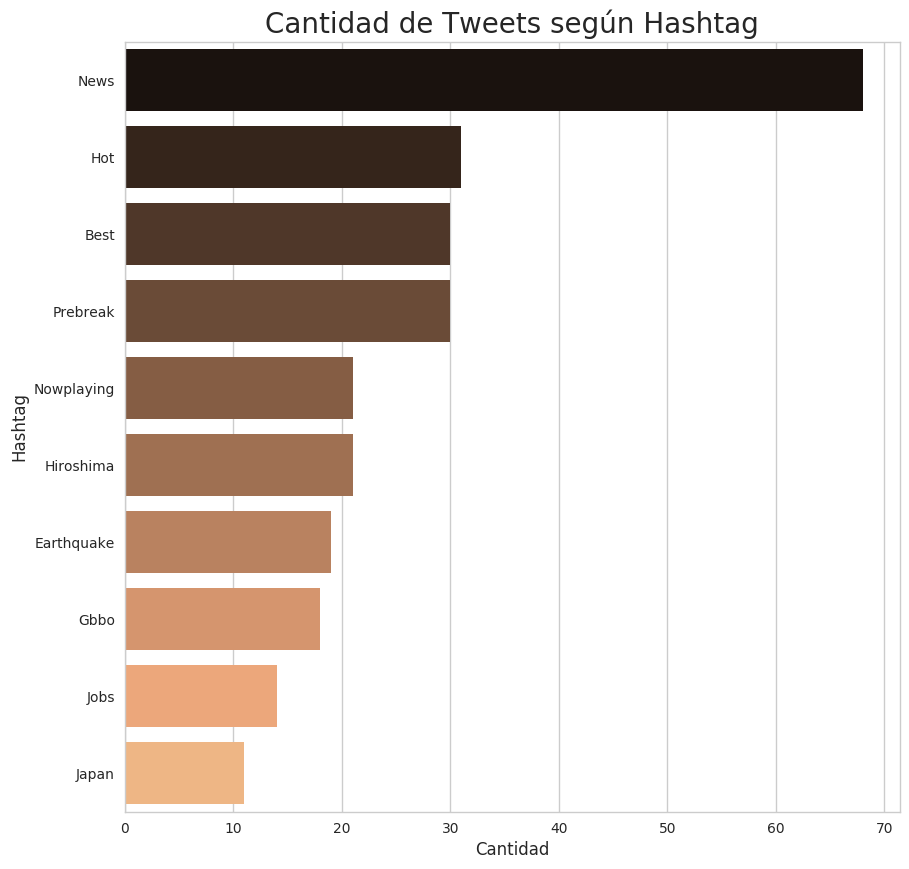

In [266]:
plt.subplots(figsize=(10,10))
grafico_hashtag_cantidad_total_top_10=sns.barplot(x=hashtag_cantidad_total_top_10['Cantidad_total'],y=hashtag_cantidad_total_top_10.index,orient='h',palette='copper')
grafico_hashtag_cantidad_total_top_10.set_title("Cantidad de Tweets según Hashtag",fontsize=20)
grafico_hashtag_cantidad_total_top_10.set_xlabel("Cantidad",fontsize=12)
grafico_hashtag_cantidad_total_top_10.set_ylabel("Hashtag",fontsize=12)

Text(95.7222,0.5,'Hashtag')

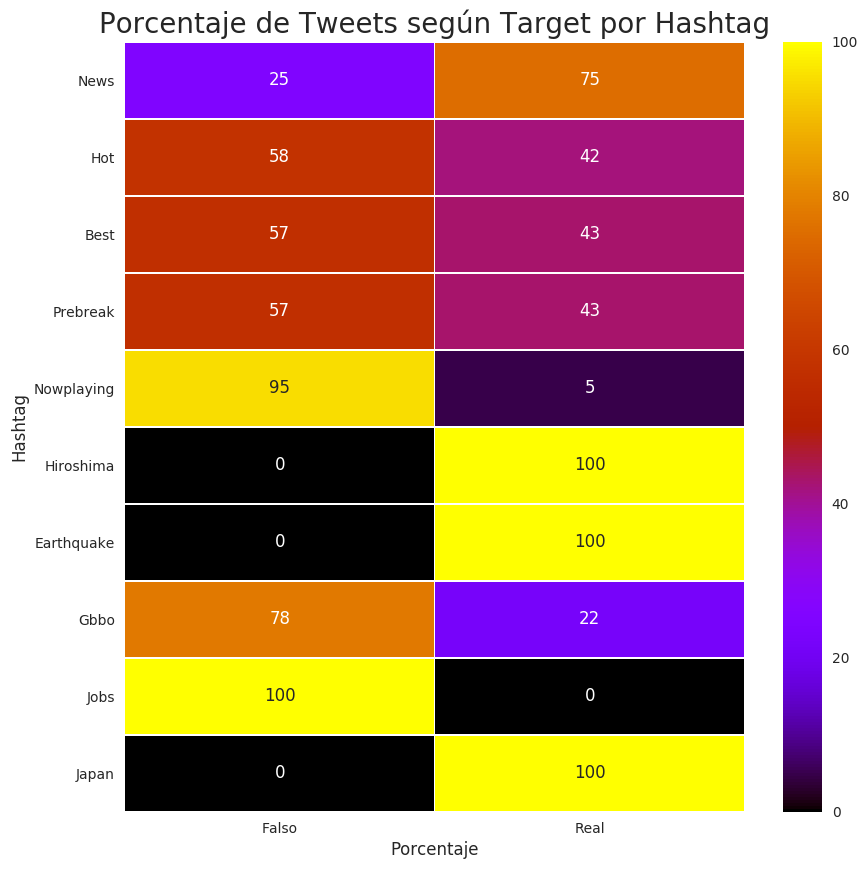

In [267]:
plt.subplots(figsize=(10,10))
grafico_hashtag_porcentaje_total_10=sns.heatmap(hashtag_porcentaje_total_10,linewidths=.5,fmt=".0f",annot=True,cmap="gnuplot")
grafico_hashtag_porcentaje_total_10.set_title("Porcentaje de Tweets según Target por Hashtag",fontsize=20)
grafico_hashtag_porcentaje_total_10.set_xlabel("Porcentaje",fontsize=12)
grafico_hashtag_porcentaje_total_10.set_ylabel("Hashtag",fontsize=12)

## 5) Cantidad segun target

In [231]:
tiene_arroba=tweets[(tweets['Tiene_arroba']==True)]
tiene_hashtag=tweets[(tweets['Tiene_hashtag']==True)]
tiene_signo_pregunta=tweets[(tweets['Tiene_signo_pregunta']==True)]
tiene_signo_exclamacion=tweets[(tweets['Tiene_signo_exclamacion']==True)]
tiene_link=tweets[(tweets['Tiene_link']==True)]
target_arroba=tiene_arroba.groupby(['target']).agg({'Tiene_arroba':'count'})
target_hashtag=tiene_hashtag.groupby(['target']).agg({'Tiene_hashtag':'count'})
target_exclamacion=tiene_signo_exclamacion.groupby(['target']).agg({'Tiene_signo_exclamacion':'count'})
target_pregunta=tiene_signo_pregunta.groupby(['target']).agg({'Tiene_signo_pregunta':'count'})
target_link=tiene_link.groupby(['target']).agg({'Tiene_link':'count'})
cantidad_target_arroba=target_arroba.reset_index()
cantidad_target_hashtag=target_hashtag.reset_index()
cantidad_target_exclamacion=target_exclamacion.reset_index()
cantidad_target_pregunta=target_pregunta.reset_index()
cantidad_target_link=target_link.reset_index()
cantidad_target=pd.merge(cantidad_target_arroba,cantidad_target_hashtag,on='target',how='inner')
cantidad_target=pd.merge(cantidad_target,cantidad_target_exclamacion,on='target',how='inner')
cantidad_target=pd.merge(cantidad_target,cantidad_target_pregunta,on='target',how='inner')
cantidad_target=pd.merge(cantidad_target,cantidad_target_link,on='target',how='inner')
cantidad_target.rename(columns={'target':'Target','Tiene_arroba':'Tiene Arroba','Tiene_hashtag':'Tiene Hashtag','Tiene_signo_exclamacion':'Tiene Exclamacion','Tiene_signo_pregunta':'Tiene Pregunta','Tiene_link':'Tiene Link'},inplace=True)
cantidad_target.replace({0:'Falso',1:'Real'},inplace=True)
cantidad_target=cantidad_target.set_index('Target')
cantidad_target=cantidad_target.transpose()
cantidad_target['Cantidad_total']=cantidad_target['Falso']+cantidad_target['Real']
cantidad_target['Porcentaje_falso']=(cantidad_target['Falso']/cantidad_target['Cantidad_total'])*100
cantidad_target['Porcentaje_real']=(cantidad_target['Real']/cantidad_target['Cantidad_total'])*100
cantidad_target.drop(columns={'Falso','Real'},inplace=True)
cantidad_target.rename(columns={'Porcentaje_falso':'Falso','Porcentaje_real':'Real'},inplace=True)
cantidad_target.sort_values(by=['Cantidad_total'],ascending=False,inplace=True)
cantidad_total_tiene=cantidad_target[['Cantidad_total']]
porcentaje_target_tiene=cantidad_target[['Falso','Real']]
cantidad_total_tiene

Target,Cantidad_total
Tiene Arroba,2039
Tiene Hashtag,1761
Tiene Pregunta,1042
Tiene Exclamacion,721
Tiene Link,407


Text(0,0.5,'Valores')

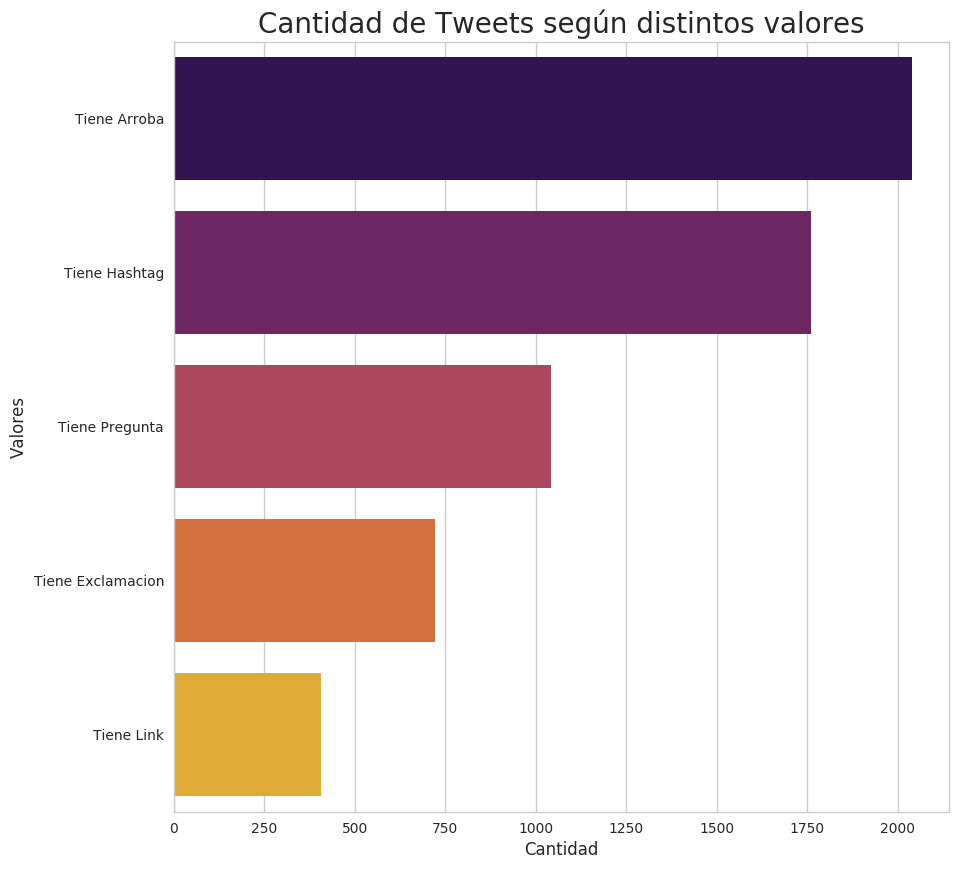

In [268]:
plt.subplots(figsize=(10,10))
grafico_cantidad_total_tiene=sns.barplot(x=cantidad_total_tiene['Cantidad_total'],y=cantidad_total_tiene.index,orient='h',palette='inferno')
grafico_cantidad_total_tiene.set_title("Cantidad de Tweets según distintos valores",fontsize=20)
grafico_cantidad_total_tiene.set_xlabel("Cantidad",fontsize=12)
grafico_cantidad_total_tiene.set_ylabel("Valores",fontsize=12)

[Text(0,0.5,'Tiene Arroba'),
 Text(0,1.5,'Tiene Hashtag'),
 Text(0,2.5,'Tiene Pregunta'),
 Text(0,3.5,'Tiene Exclamacion'),
 Text(0,4.5,'Tiene Link')]

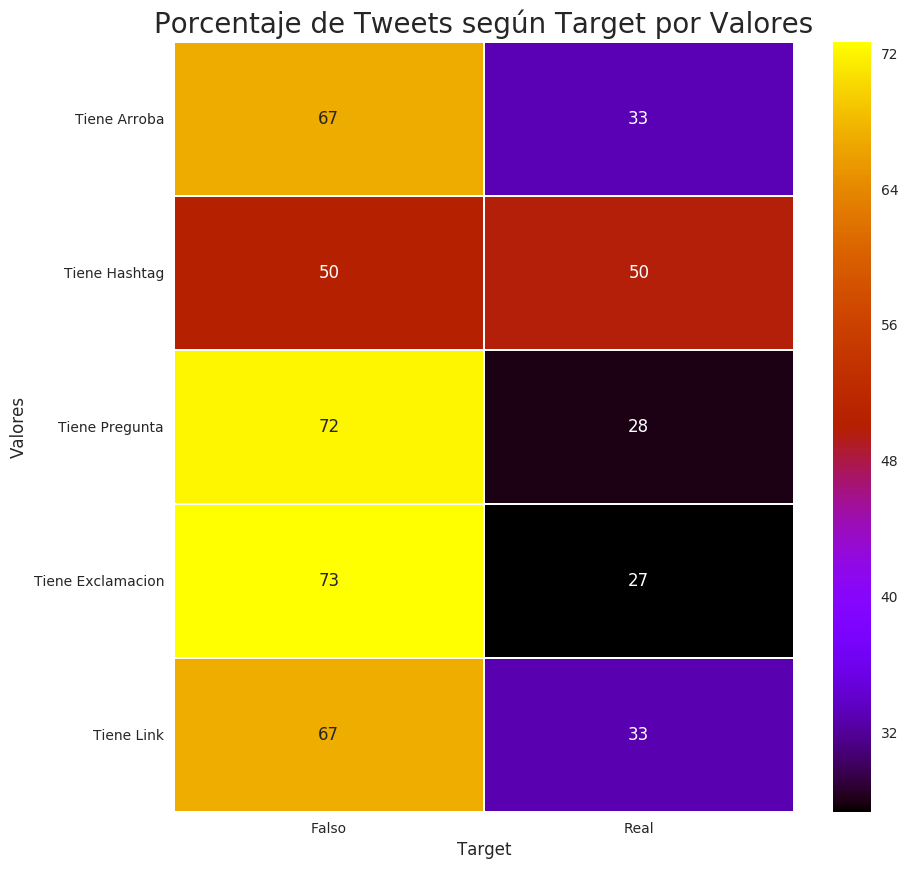

In [269]:
plt.subplots(figsize=(10,10))
grafico_porcentaje_target_tiene=sns.heatmap(porcentaje_target_tiene,linewidths=.5,fmt=".0f",annot=True,cmap="gnuplot")
grafico_porcentaje_target_tiene.set_title("Porcentaje de Tweets según Target por Valores",fontsize=20)
grafico_porcentaje_target_tiene.set_xlabel("Target",fontsize=12)
grafico_porcentaje_target_tiene.set_ylabel("Valores",fontsize=12)
grafico_porcentaje_target_tiene.set_yticklabels(grafico_porcentaje_target_tiene.get_yticklabels(),rotation=0)

## 7) Top Keywords

In [234]:
#Me quedo con el top 10 de keywords
top_10_keywords=tweets['keyword'].value_counts().reset_index()
top_10_keywords=top_10_keywords.head(10)
top_10_keywords.drop(columns={'keyword'},inplace=True)
top_10_keywords.rename(columns={'index':'keyword'},inplace=True)
top_10_keywords

,keyword
0,fatalities
1,armageddon
2,deluge
3,damage
4,harm
5,body%20bags
6,sinking
7,twister
8,collided
9,evacuate


In [235]:
cantidad_tweets_keywords=tweets[['keyword','target']].copy()
cantidad_tweets_keywords=pd.merge(cantidad_tweets_keywords,top_10_keywords,on='keyword',how='inner')
cantidad_tweets_keywords['Valor']=1
keywords_target_cantidad=cantidad_tweets_keywords.pivot_table(index='keyword',columns='target',values='Valor',aggfunc='sum')
keywords_target_cantidad.fillna(0,inplace=True)
keywords_target_cantidad['Cantidad_total']=keywords_target_cantidad[0]+keywords_target_cantidad[1]
keywords_target_cantidad['Falso']=(keywords_target_cantidad[0]/keywords_target_cantidad['Cantidad_total'])*100
keywords_target_cantidad['Real']=(keywords_target_cantidad[1]/keywords_target_cantidad['Cantidad_total'])*100
keywords_target_cantidad.drop(columns={0,1},inplace=True)
keywords_target_cantidad.sort_values(by=['Cantidad_total'],ascending=False,inplace=True)
keywords_cantidad_total=keywords_target_cantidad[['Cantidad_total']]
keywords_porcentaje_target=keywords_target_cantidad[['Falso','Real']]
keywords_cantidad_total

target,Cantidad_total
keyword,
fatalities,45
armageddon,42
deluge,42
body%20bags,41
damage,41
harm,41
sinking,41
collided,40
evacuate,40


Text(0,0.5,'Keyword')

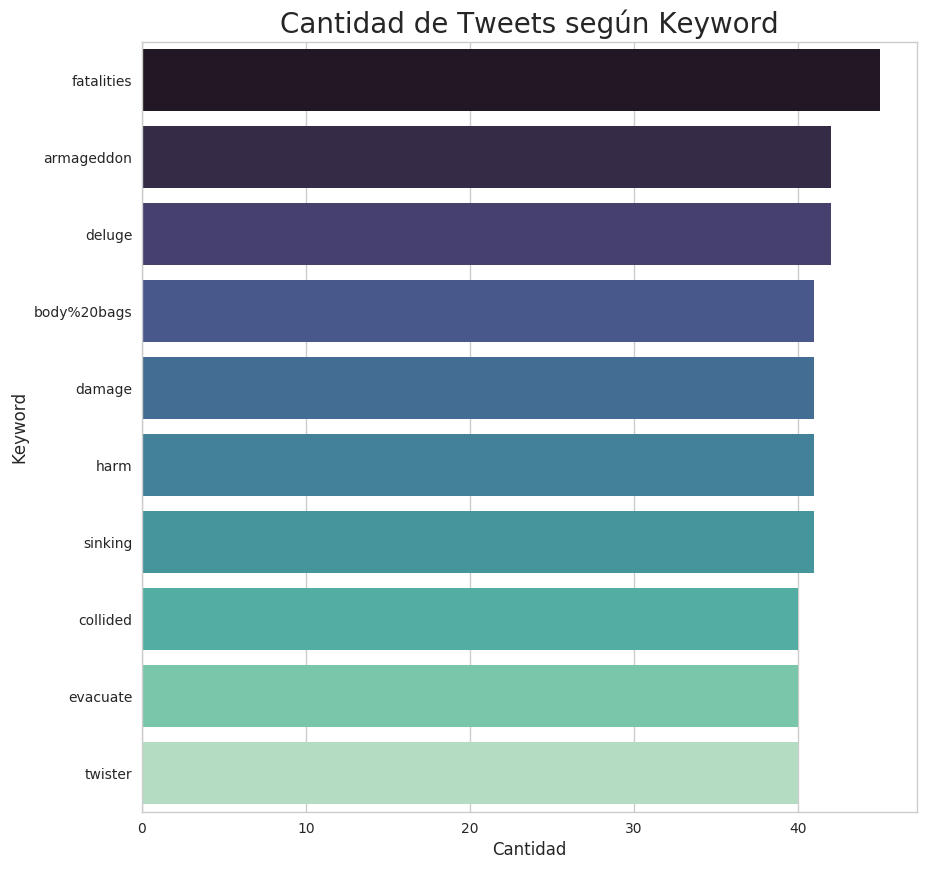

In [270]:
plt.subplots(figsize=(10,10))
grafico_keywords_cantidad_total=sns.barplot(x=keywords_cantidad_total['Cantidad_total'],y=keywords_cantidad_total.index,orient='h',palette='mako')
grafico_keywords_cantidad_total.set_title("Cantidad de Tweets según Keyword",fontsize=20)
grafico_keywords_cantidad_total.set_xlabel("Cantidad",fontsize=12)
grafico_keywords_cantidad_total.set_ylabel("Keyword",fontsize=12)

Text(95.7222,0.5,'Keyword')

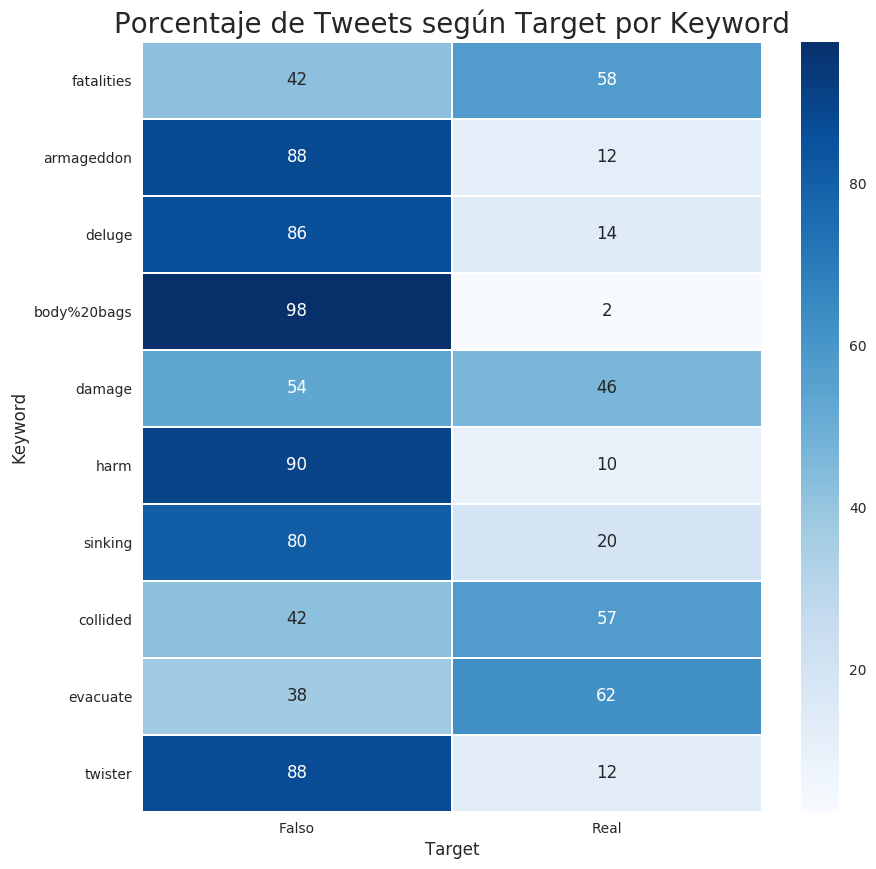

In [271]:
plt.subplots(figsize=(10,10))
grafico_keywords_porcentaje_target=sns.heatmap(keywords_porcentaje_target,linewidths=.5,fmt=".0f",annot=True,cmap="Blues")
grafico_keywords_porcentaje_target.set_title("Porcentaje de Tweets según Target por Keyword",fontsize=20)
grafico_keywords_porcentaje_target.set_xlabel("Target",fontsize=12)
grafico_keywords_porcentaje_target.set_ylabel("Keyword",fontsize=12)

## 7) Locacion con Keyword

In [238]:
#Me quedo con el top 10 de los paises con mayor cantidad de tweets
top_10_paises_cantidad_tweets=cantidad_pais_total[['Pais','Cantidad_total']].copy()
top_10_paises_cantidad_tweets.sort_values(by=['Cantidad_total'],ascending=False,inplace=True)
top_10_paises_cantidad_tweets=top_10_paises_cantidad_tweets.head(10)
top_10_paises_cantidad_tweets.drop(columns={'Cantidad_total'},inplace=True)
top_10_paises_cantidad_tweets

,Pais
4,United States
3,Canada
143,United Kingdom
137,Australia
98,India
56,Nigeria
9,Argentina
147,Philippines
13,Kenya
25,South Africa


In [239]:
separacion_coma.drop(columns={'Tiene_arroba','Tiene_hashtag','Tiene_signo_exclamacion','Tiene_signo_pregunta'},inplace=True)
separacion_coma.head()

,id,keyword,text,target,Tiene_link,Primero,Segundo,Tercero,Es_USA
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,False,Birmingham,None,None,0
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,False,Est. September 2012 - Bristol,None,None,0
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,False,AFRICA,None,None,0
34,52,ablaze,Crying out for more! Set me ablaze,0,False,Philadelphia,PA,None,0
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,False,London,UK,None,0


In [240]:
mundo_keyword=mundo[['name','iso_a3']].copy()
mundo_keyword['Pais']=mundo_keyword['name']
mundo_keyword.head()

,name,iso_a3,Pais
0,Fiji,FJI,Fiji
1,Tanzania,TZA,Tanzania
2,W. Sahara,ESH,W. Sahara
3,Canada,CAN,Canada
4,United States,USA,United States


In [241]:
mundo_keyword_primero=mundo_keyword.copy()
primero_keyword_pais=separacion_coma[['id','Primero']].copy()
primero_keyword_pais.rename(columns={'Primero':'name'},inplace=True)
primero_keyword_pais=pd.merge(primero_keyword_pais,mundo_keyword_primero,on='name',how='left')
primero_keyword_pais.drop(columns={'iso_a3'},inplace=True)
mundo_keyword_primero.drop(columns={'name'},inplace=True)
mundo_keyword_primero.rename(columns={'iso_a3':'name',},inplace=True)
primero_keyword_pais=pd.merge(primero_keyword_pais,mundo_keyword_primero,on='name',how='left')
primero_keyword_pais['Pais_final']=primero_keyword_pais.apply(lambda x: MeQuedoConPais(x['Pais_x'],x['Pais_y']),axis=1)
primero_keyword_pais.drop(columns={'Pais_x','Pais_y','name'},inplace=True)
primero_keyword_pais=primero_keyword_pais[(primero_keyword_pais['Pais_final']!='Vacio')]
primero_keyword_pais.head()

,id,Pais_final
14,74,India
18,79,United States
19,80,South Africa
35,105,Australia
59,151,Switzerland


In [242]:
mundo_keyword_segundo=mundo_keyword.copy()
segundo_keyword_pais=separacion_coma[['id','Segundo']].copy()
segundo_keyword_pais.rename(columns={'Segundo':'name'},inplace=True)
segundo_keyword_pais=pd.merge(segundo_keyword_pais,mundo_keyword_segundo,on='name',how='left')
segundo_keyword_pais.drop(columns={'iso_a3'},inplace=True)
mundo_keyword_segundo.drop(columns={'name'},inplace=True)
mundo_keyword_segundo.rename(columns={'iso_a3':'name',},inplace=True)
segundo_keyword_pais=pd.merge(segundo_keyword_pais,mundo_keyword_segundo,on='name',how='left')
segundo_keyword_pais['Pais_final']=segundo_keyword_pais.apply(lambda x: MeQuedoConPais(x['Pais_x'],x['Pais_y']),axis=1)
segundo_keyword_pais.drop(columns={'Pais_x','Pais_y','name'},inplace=True)
segundo_keyword_pais=segundo_keyword_pais[(segundo_keyword_pais['Pais_final']!='Vacio')]
segundo_keyword_pais.head()

,id,Pais_final
20,81,Brazil
40,114,Kenya
56,145,Kenya
72,173,Canada
87,204,India


In [243]:
mundo_keyword_tercero=mundo_keyword.copy()
tercero_keyword_pais=separacion_coma[['id','Tercero']].copy()
tercero_keyword_pais.rename(columns={'Tercero':'name'},inplace=True)
tercero_keyword_pais=pd.merge(tercero_keyword_pais,mundo_keyword_tercero,on='name',how='left')
tercero_keyword_pais.drop(columns={'iso_a3'},inplace=True)
mundo_keyword_tercero.drop(columns={'name'},inplace=True)
mundo_keyword_tercero.rename(columns={'iso_a3':'name',},inplace=True)
tercero_keyword_pais=pd.merge(tercero_keyword_pais,mundo_keyword_tercero,on='name',how='left')
tercero_keyword_pais['Pais_final']=tercero_keyword_pais.apply(lambda x: MeQuedoConPais(x['Pais_x'],x['Pais_y']),axis=1)
tercero_keyword_pais.drop(columns={'Pais_x','Pais_y','name'},inplace=True)
tercero_keyword_pais=tercero_keyword_pais[(tercero_keyword_pais['Pais_final']!='Vacio')]
tercero_keyword_pais.head()

,id,Pais_final
178,404,United States
337,738,United States
535,1175,United States
777,1723,Australia
873,1922,Australia


In [244]:
keyword_pais_total=pd.merge(primero_keyword_pais,segundo_keyword_pais,on='id',how='outer')
keyword_pais_total=pd.merge(keyword_pais_total,tercero_keyword_pais,on='id',how='outer')
keyword_pais_total['Pais']=keyword_pais_total.apply(lambda x: KeywordPaisFinal(x['Pais_final_x'],x['Pais_final_y'],x['Pais_final']),axis=1)
keyword_pais_total=keyword_pais_total[(keyword_pais_total['Pais']!='Vacio')]
keyword_pais_total.drop(columns={'Pais_final_x','Pais_final_y','Pais_final'},inplace=True)
keyword_pais_total.head()

,id,Pais
0,74,India
1,79,United States
2,80,South Africa
3,105,Australia
4,151,Switzerland


In [245]:
top_keyword_pais=tweets[['id','keyword']].copy()
top_keyword_pais=pd.merge(top_keyword_pais,keyword_pais_total,on='id',how='inner')
top_keyword_pais=pd.merge(top_keyword_pais,top_10_paises_cantidad_tweets,on='Pais',how='inner')
top_keyword_pais=pd.merge(top_keyword_pais,top_10_keywords,on='keyword',how='inner')
top_keyword_pais['Valor']=1
top_keyword_pais.head()

,id,keyword,Pais,Valor
0,446,armageddon,United States,1
1,447,armageddon,United States,1
2,461,armageddon,United States,1
3,462,armageddon,United States,1
4,465,armageddon,United States,1


In [246]:
keyword_pais=top_keyword_pais.pivot_table(index='Pais',columns='keyword',values='Valor',aggfunc='sum')
keyword_pais.fillna(0,inplace=True)

keyword_pais

keyword,armageddon,body%20bags,collided,damage,deluge,evacuate,fatalities,harm,sinking,twister
Pais,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Australia,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
Canada,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
Kenya,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
South Africa,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
United Kingdom,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
United States,6.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


[Text(0.5,0,'armageddon'),
 Text(1.5,0,'body%20bags'),
 Text(2.5,0,'collided'),
 Text(3.5,0,'damage'),
 Text(4.5,0,'deluge'),
 Text(5.5,0,'evacuate'),
 Text(6.5,0,'fatalities'),
 Text(7.5,0,'harm'),
 Text(8.5,0,'sinking'),
 Text(9.5,0,'twister')]

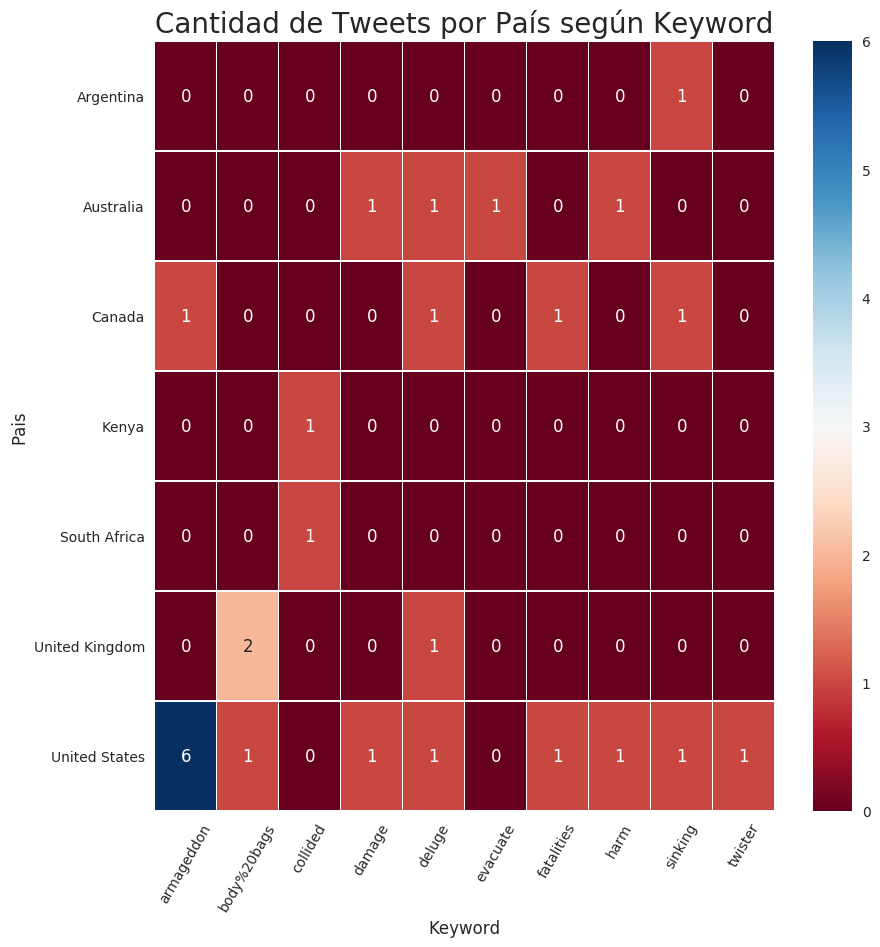

In [272]:
plt.subplots(figsize=(10,10))
grafico_keyword_pais=sns.heatmap(keyword_pais,linewidths=.5,fmt=".0f",annot=True,cmap="RdBu")
grafico_keyword_pais.set_title("Cantidad de Tweets por País según Keyword",fontsize=20)
grafico_keyword_pais.set_xlabel("Keyword",fontsize=12)
grafico_keyword_pais.set_ylabel("Pais",fontsize=12)
grafico_keyword_pais.set_xticklabels(grafico_keyword_pais.get_xticklabels(),rotation=60)

## 8) Nulos

### 8.1) Target

In [248]:
nulos_keyword=tweets[(pd.isna(tweets['keyword']))]
nulos_location=tweets[(pd.isna(tweets['location']))]
cantidad_tweets_nulo_keyword=nulos_keyword['target'].count()
cantidad_tweets_nulo_location=nulos_location['target'].count()

In [249]:
target_nulos_keyword=nulos_keyword['target'].value_counts().reset_index()
target_nulos_location=nulos_location['target'].value_counts().reset_index()
target_nulos_keyword.rename(columns={'target':'Keyword','index':'Target'},inplace=True)
target_nulos_location.rename(columns={'target':'Location','index':'Target'},inplace=True)
target_nulos=pd.merge(target_nulos_keyword,target_nulos_location,on='Target',how='inner')
target_nulos.replace({1:'Real',0:'Falso'},inplace=True)
target_nulos.set_index('Target',inplace=True)
target_nulos['Keyword']=(target_nulos['Keyword']/cantidad_tweets_nulo_keyword)*100
target_nulos['Location']=(target_nulos['Location']/cantidad_tweets_nulo_location)*100
target_nulos

,Keyword,Location
Target,,
Real,68.852459,42.439795
Falso,31.147541,57.560205


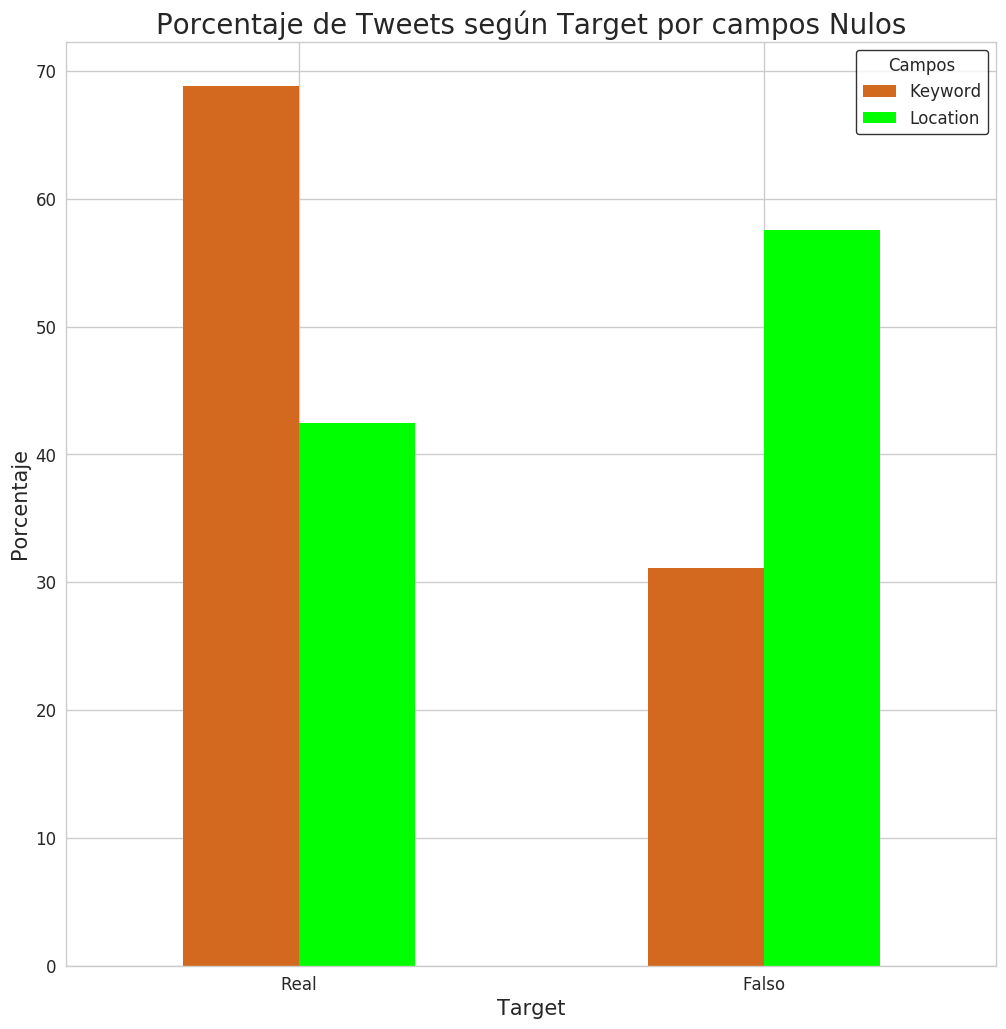

In [250]:
grafico_target_nulos=target_nulos.plot(kind='bar',color=['chocolate','lime'],fontsize=12,figsize=(12,12),rot=0)
grafico_target_nulos.set_title('Porcentaje de Tweets según Target por campos Nulos',fontsize=20)
grafico_target_nulos.set_xlabel('Target',fontsize=15)
grafico_target_nulos.set_ylabel('Porcentaje',fontsize=15)
leyenda=plt.legend(['Keyword','Location'],fontsize=12,title='Campos',frameon=True,facecolor='white',edgecolor='black')
leyenda.get_frame().set_linewidth(1.0)

### 8.2) Keyword con Paises

In [251]:
nulos_keyword['location'].value_counts()

Series([], Name: location, dtype: int64)

Se puede ver que con el keyword en nulo, tambien la locacion es nula, por lo que no hay mucho para analizar

## 9) General

In [252]:
cantidad_total_tweets=tweets['text'].count()
porcentaje_target=tweets['target'].value_counts().reset_index()
porcentaje_target['Porcentaje']=(porcentaje_target['target']/cantidad_total_tweets)*100
porcentaje_target.drop(columns={'target'},inplace=True)
porcentaje_target.rename(columns={'index':'Target'},inplace=True)
porcentaje_target.replace({0:'Falso',1:'Real'},inplace=True)
porcentaje_target.set_index('Target',inplace=True)
porcentaje_target

,Porcentaje
Target,
Falso,57.034021
Real,42.965979


Text(0,0.5,'')

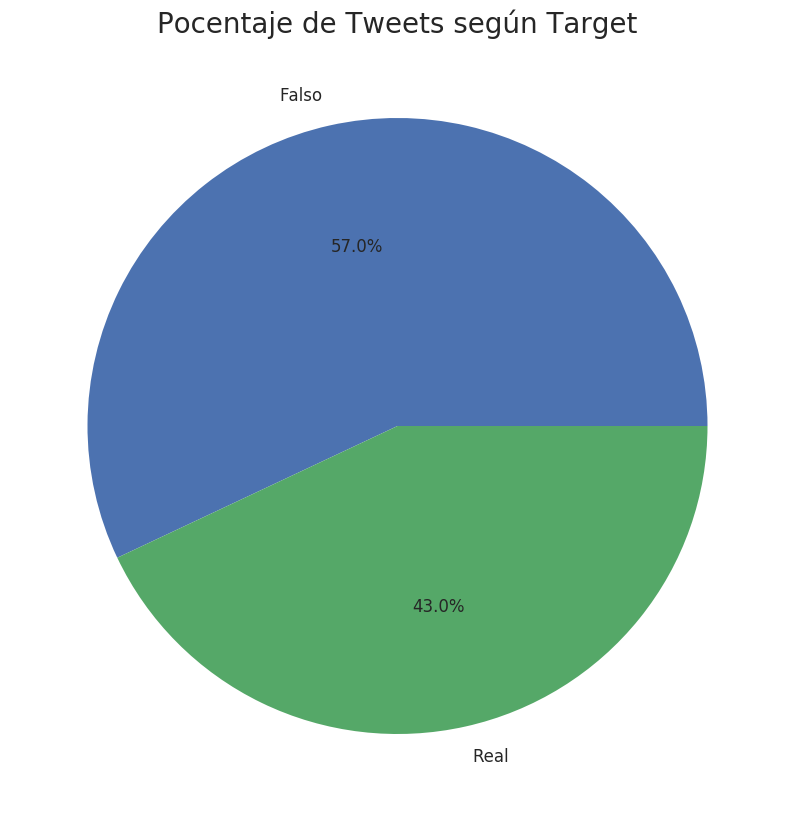

In [253]:
grafico_porcentaje_target=porcentaje_target.plot(kind='pie',y='Porcentaje',figsize=(10,10),fontsize=12,autopct='%1.1f%%',legend=False)
grafico_porcentaje_target.set_title("Pocentaje de Tweets según Target",fontsize=20)
grafico_porcentaje_target.set_ylabel("")